### DLthon 진행 과정
- 1일차: 베이스라인 선정 및 Featuere Engineering 에 집중
- 2일차: 정칙화와 LaneNet를 통한 lane Mark 개선에 집중
- 3일차: 상호지식 증류를 통한 Lane Mark 개선 시도

### 1일차 Task
 #### 목표
 - 프로젝트 파악 및 팀원 역할 배분
 - 모델 데이터 확인(파악)
 - 베이스라인 모델 선정 및 지표 결정
 - Feature Engineering을 통한 성능 개선
   
 #### Process
- Segment Baseline 구조 결정 → DeepLab v3 vs U-Net
- backbone 결정 → ResNet50 vs EffientNetB0

- W&B 설계, Grad-CAM 미적용

### Steps
 - 1. 데이터 파악(EDA)
 - 2. DeepLab v3(ResNet50) 성능(지표)
 - 3. Unet(ResNet50) 성능(지표)
 - 4. DeepLab v3(EffientNetB0) 성능(지표)
 - 5. DeepLab v3(ResNet50) 기반 Feature Engineering

### 결과 해석

- Segmentation 구조로 DeepLab v3 선정
- Backbone 결정(ResNet50)
- 다양한 Feature Engineering 진행

### 회고
- Lane Mark를 개선하기 위해 우리가 배운 지식을 총동원하였으나 개선에 실패함
- 팀원들간의 소통을 통하여 아이디어는 폭발함
- Feature Engineering을 좀 더 파악함
- 실패는 성공의 어머니가 되기를 기도함.

### 1. 데이터 파악(EDA)

In [1]:
import os
from pathlib import Path
import json
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

# ===== 로컬 경로  =====
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ann_path  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

print("DATA_ROOT:", DATA_ROOT)
print("IMG_DIR  :", IMG_DIR)
print("ann_path :", ann_path)

print("\n[DATA_ROOT list]")
print(os.listdir(DATA_ROOT))

# ===== COCO JSON 로드 (클라우드 코드와 동일 흐름) =====
with open(ann_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

print("\nkeys:", coco_data.keys())
print("num images:", len(coco_data["images"]))
print("num annotations:", len(coco_data["annotations"]))
print("num categories:", len(coco_data["categories"]))

DATA_ROOT: D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset
IMG_DIR  : D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\images
ann_path : D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset\COCO_motorcycle (pixel).json

[DATA_ROOT list]
['COCO_motorcycle (pixel).json', 'images', 'mask_cache_512']

keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])
num images: 200
num annotations: 2305
num categories: 6


In [3]:
# ===============================
# COCO Dataset EDA 
# ===============================

import json
import pandas as pd

# ---- COCO JSON 로드 ----
with open(ann_path, "r", encoding="utf-8") as f:
    coco_data = json.load(f)

print("===== COCO STRUCTURE =====")
print("keys:", coco_data.keys())

# ---- 카테고리 매핑 ----
cat_id_to_name = {c["id"]: c["name"] for c in coco_data["categories"]}
cat_name_to_id = {c["name"]: c["id"] for c in coco_data["categories"]}


# ==========================================================
# 1) INFO
# ==========================================================
print("\n===== DATASET INFO =====")

info = coco_data.get("info", {})
display(pd.DataFrame([info]))


# ==========================================================
# 2) LICENSES
# ==========================================================
print("\n===== LICENSES =====")

licenses = coco_data.get("licenses", [])
print("num_licenses:", len(licenses))
display(pd.DataFrame(licenses))


# ==========================================================
# 3) IMAGES 분석
# ==========================================================
print("\n===== IMAGES ANALYSIS =====")

images = coco_data["images"]
print("num_images:", len(images))

img_df = pd.DataFrame(images)

print("image columns:", img_df.columns.tolist())
display(img_df.head(3))

# ---- 해상도 통계 ----
if "width" in img_df.columns and "height" in img_df.columns:
    
    print("\n[Resolution stats]")
    print("width  min/mean/median/max:",
          int(img_df["width"].min()),
          round(img_df["width"].mean(), 2),
          img_df["width"].median(),
          int(img_df["width"].max()))

    print("height min/mean/median/max:",
          int(img_df["height"].min()),
          round(img_df["height"].mean(), 2),
          img_df["height"].median(),
          int(img_df["height"].max()))

    res_counts = (
        img_df.groupby(["width", "height"])
        .size()
        .sort_values(ascending=False)
        .head(5)
    )

    print("\nTop resolutions:")
    display(res_counts)


# ---- 파일명 패턴 ----
if "file_name" in img_df.columns:

    print("\n[file_name examples]")
    display(img_df["file_name"].head(10))

    has_subdir = img_df["file_name"].str.contains("/").mean()
    print(f"file_name에 하위 폴더 포함 비율: {has_subdir*100:.1f}%")


# ==========================================================
# 4) CATEGORIES 분석
# ==========================================================
print("\n===== CATEGORY ANALYSIS =====")

cat_df = pd.DataFrame(coco_data["categories"]).sort_values("id")
display(cat_df)

print("\n[Category list]")
for c in coco_data["categories"]:
    print(f"{c['id']} : {c['name']}")

===== COCO STRUCTURE =====
keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

===== DATASET INFO =====


,description,url,version,year,contributor,date_created
0,This is dataset.,https://superannotate.ai,1.0,2022,Superannotate AI,15/09/2022



===== LICENSES =====
num_licenses: 1


,url,id,name
0,https://superannotate.ai,1,Superannotate AI



===== IMAGES ANALYSIS =====
num_images: 200
image columns: ['id', 'file_name', 'height', 'width', 'license']


,id,file_name,height,width,license
0,1,night ride (8).png,1080,1920,1
1,2,night ride (14).png,1080,1920,1
2,3,night ride (11).png,1080,1920,1



[Resolution stats]
width  min/mean/median/max: 1920 1920.0 1920.0 1920
height min/mean/median/max: 1080 1080.0 1080.0 1080

Top resolutions:


width  height
1920   1080      200
dtype: int64


[file_name examples]


0     night ride (8).png
1    night ride (14).png
2    night ride (11).png
3    night ride (24).png
4    night ride (23).png
5    night ride (10).png
6     night ride (9).png
7    night ride (20).png
8    night ride (12).png
9    night ride (17).png
Name: file_name, dtype: object

file_name에 하위 폴더 포함 비율: 0.0%

===== CATEGORY ANALYSIS =====


,id,name,supercategory,isthing,color
5,1323880,Undrivable,Undrivable,1,"[104, 51, 20]"
4,1323881,Road,Road,1,"[105, 51, 20]"
3,1323882,Lane Mark,Lane Mark,1,"[106, 51, 20]"
2,1323884,Moveable,Moveable,1,"[108, 51, 20]"
1,1323885,My bike,My bike,1,"[109, 51, 20]"
0,1329681,Rider,Rider,1,"[17, 74, 20]"



[Category list]
1329681 : Rider
1323885 : My bike
1323884 : Moveable
1323882 : Lane Mark
1323881 : Road
1323880 : Undrivable


In [5]:
# ===============================
# 5) ANNOTATIONS EDA (통합 셀)
# ===============================

import numpy as np
import pandas as pd

annotations = coco_data["annotations"]
print("\n===== ANNOTATIONS ANALYSIS =====")
print("num_annotations:", len(annotations))

ann_df = pd.DataFrame(annotations)
print("annotation columns:", ann_df.columns.tolist())
display(ann_df.head(3))


# ==========================================================
# 5-2) 클래스별 annotation 개수 (category_id 기준)
# ==========================================================
print("\n===== PER-CLASS ANNOTATION COUNT =====")

cat_counts = ann_df["category_id"].value_counts()

summary_df = pd.DataFrame({
    "category_id": cat_counts.index.astype(int),
    "category_name": [cat_id_to_name.get(int(cid), "UNKNOWN") for cid in cat_counts.index],
    "ann_count": cat_counts.values.astype(int),
    "ann_ratio(%)": (cat_counts.values / len(ann_df) * 100)
})

display(summary_df)


# ==========================================================
# 5-3) 이미지당 annotation 개수 분포
# ==========================================================
print("\n===== ANNOTATIONS PER IMAGE =====")

ann_per_img = ann_df.groupby("image_id").size()
print("images with annotations:", ann_per_img.shape[0], "/", len(images))
print("anns per image: min/mean/median/max =",
      int(ann_per_img.min()),
      round(float(ann_per_img.mean()), 3),
      float(ann_per_img.median()),
      int(ann_per_img.max()))

display(ann_per_img.describe())


# ==========================================================
# 5-4) area / bbox 통계
# ==========================================================
print("\n===== AREA / BBOX STATS =====")

# ---- area ----
if "area" in ann_df.columns:
    print("\n[Area stats]")
    print("area min/mean/median/max =",
          float(ann_df["area"].min()),
          round(float(ann_df["area"].mean()), 3),
          float(ann_df["area"].median()),
          float(ann_df["area"].max()))

    area_by_cat = (
        ann_df.groupby("category_id")["area"]
        .agg(["count","mean","median","min","max"])
        .reset_index()
    )
    area_by_cat["category_name"] = area_by_cat["category_id"].map(cat_id_to_name)
    area_by_cat = area_by_cat.sort_values("mean")

    print("\n[Area stats by category (sorted by mean)]")
    display(area_by_cat)

else:
    print("⚠️ 'area' column not found in annotations.")


# ---- bbox ----
if "bbox" in ann_df.columns:
    # bbox = [x, y, w, h]
    wh = np.array([
        b[2:4] for b in ann_df["bbox"].values
        if isinstance(b, list) and len(b) >= 4
    ])

    if len(wh) > 0:
        w = wh[:, 0]
        h = wh[:, 1]

        print("\n[BBox width/height stats]")
        print("w min/mean/median/max:",
              float(w.min()), round(float(w.mean()), 3), float(np.median(w)), float(w.max()))
        print("h min/mean/median/max:",
              float(h.min()), round(float(h.mean()), 3), float(np.median(h)), float(h.max()))

        bbox_df = pd.DataFrame({
            "w": w,
            "h": h,
            "bbox_area(w*h)": w*h
        })
        display(bbox_df.describe())

    else:
        print("⚠️ bbox는 존재하지만, 파싱 가능한 bbox 리스트가 없습니다.")
else:
    print("⚠️ 'bbox' column not found in annotations.")



===== ANNOTATIONS ANALYSIS =====
num_annotations: 2305
annotation columns: ['id', 'image_id', 'segmentation', 'iscrowd', 'bbox', 'area', 'category_id']


,id,image_id,segmentation,iscrowd,bbox,area,category_id
0,1,1,"[[0, 0, 0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 6, 0,...",0,"[0.0, 0.0, 1920.0, 551.0]",586530,1323880
1,2,1,"[[1383, 932, 1382, 933, 1381, 934, 1380, 934, ...",0,"[0.0, 243.0, 1920.0, 837.0]",819509,1323881
2,3,1,"[[884, 524, 883, 525, 882, 525, 881, 525, 880,...",0,"[0.0, 280.0, 1659.0, 277.0]",17414,1323882



===== PER-CLASS ANNOTATION COUNT =====


,category_id,category_name,ann_count,ann_ratio(%)
0,1323884,Moveable,1298,56.312364
1,1323882,Lane Mark,207,8.980477
2,1323881,Road,200,8.676790
3,1323880,Undrivable,200,8.676790
4,1323885,My bike,200,8.676790
5,1329681,Rider,200,8.676790



===== ANNOTATIONS PER IMAGE =====
images with annotations: 200 / 200
anns per image: min/mean/median/max = 5 11.525 11.0 26


count    200.000000
mean      11.525000
std        4.504534
min        5.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       26.000000
dtype: float64


===== AREA / BBOX STATS =====

[Area stats]
area min/mean/median/max = 5.0 179919.144 14907.0 1515454.0

[Area stats by category (sorted by mean)]


,category_id,count,mean,median,min,max,category_name
3,1323884,1298,15041.065485,1692.0,5,424086,Moveable
2,1323882,207,28824.676329,22196.0,103,170137,Lane Mark
5,1329681,200,167151.545000,181064.5,40709,269838,Rider
4,1323885,200,327562.445000,319764.0,108350,711443,My bike
1,1323881,200,562131.875000,593954.0,146843,1035064,Road
0,1323880,200,889272.210000,893769.5,351188,1515454,Undrivable



[BBox width/height stats]
w min/mean/median/max: 1.0 792.071 259.0 1920.0
h min/mean/median/max: 2.0 293.641 162.0 1080.0


,w,h,bbox_area(w*h)
count,2305.000000,2305.000000,2.305000e+03
mean,792.070716,293.640781,4.353286e+05
std,817.403358,286.571006,5.629247e+05
min,1.000000,2.000000,5.000000e+00
25%,47.000000,42.000000,1.960000e+03
50%,259.000000,162.000000,4.006800e+04
75%,1920.000000,533.000000,8.198400e+05
max,1920.000000,1080.000000,2.073600e+06


===== FILE MATCH CHECK =====
missing files: 0

===== BASIC COUNTS =====
이미지 수: 200
annotation 수: 2305

===== SAMPLE VISUALIZATION =====
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


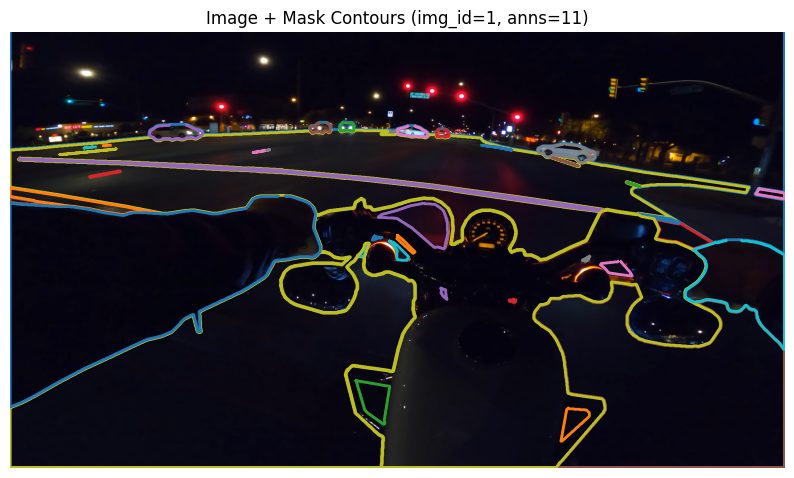

In [7]:
# ===============================
# 6) 파일 매칭 체크 + 샘플 시각화 (통합 셀)
# ===============================

import os, json
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) images 폴더와 JSON 매칭 체크 ----
img_dir = os.path.join(DATA_ROOT, "images")

missing = []
for im in images:
    fp = os.path.join(img_dir, im["file_name"])
    if not os.path.exists(fp):
        missing.append(im["file_name"])

print("===== FILE MATCH CHECK =====")
print("missing files:", len(missing))
if len(missing) > 0:
    print("ex) missing sample:", missing[:5])

# ---- 2) 이미지/annotation 수 ----
print("\n===== BASIC COUNTS =====")
print("이미지 수:", len(coco_data["images"]))
print("annotation 수:", len(coco_data["annotations"]))

# ---- 3) 샘플 이미지 + 마스크 윤곽선 시각화 ----
print("\n===== SAMPLE VISUALIZATION =====")

# OpenCV / pycocotools import (없으면 설치 필요)
import cv2
from pycocotools.coco import COCO

coco = COCO(ann_path)

# 첫 샘플 선택
img_id = coco.getImgIds()[0]
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(DATA_ROOT, "images", img_info["file_name"])

# 이미지 읽기
image = cv2.imread(img_path)
if image is None:
    raise FileNotFoundError(f"cv2.imread failed: {img_path}")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# annotation 가져오기
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

plt.figure(figsize=(10, 8))
plt.imshow(image)
ax = plt.gca()

# 윤곽선 그리기
for ann in anns:
    mask = coco.annToMask(ann).astype(np.uint8)  # (H,W) 0/1

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contours:
        cnt = cnt.squeeze()
        if cnt.ndim == 2 and len(cnt) >= 3:
            ax.plot(cnt[:, 0], cnt[:, 1], linewidth=2)

plt.title(f"Image + Mask Contours (img_id={img_id}, anns={len(anns)})")
plt.axis("off")
plt.show()


===== CLASS DISTRIBUTION (Annotation 기준) =====


,category_id,category_name,annotation_count,ratio(%)
0,1323884,Moveable,1298,56.31
1,1323882,Lane Mark,207,8.98
2,1323881,Road,200,8.68
3,1323880,Undrivable,200,8.68
4,1323885,My bike,200,8.68
5,1329681,Rider,200,8.68


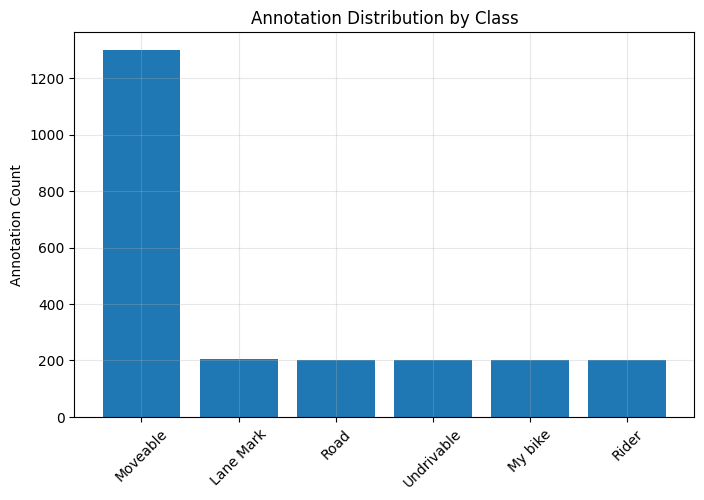


===== NIGHT BRIGHTNESS ANALYSIS =====
Valid images loaded: 200
Mean Brightness: 45.66
Median Brightness: 33.61
Std Brightness: 26.01
Min Brightness: 10.35
Max Brightness: 120.78


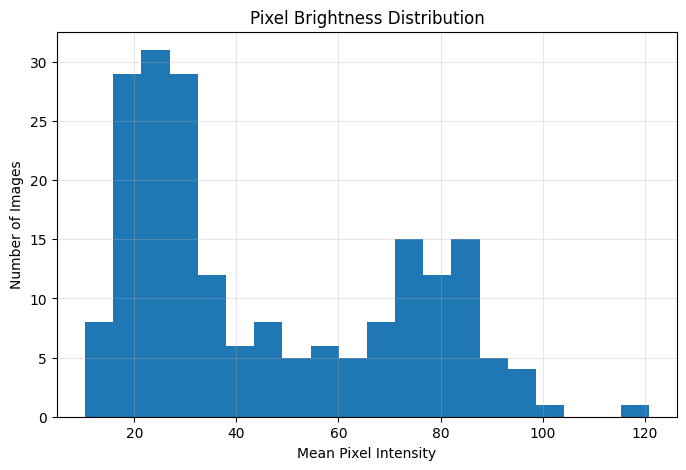

In [9]:
# ===============================
# CLASS DISTRIBUTION + NIGHT BRIGHTNESS ANALYSIS
# ===============================

from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os


# ==========================================================
# 1) 클래스 분포 분석 (annotation 기준)
# ==========================================================
print("\n===== CLASS DISTRIBUTION (Annotation 기준) =====")

cls_counter = Counter(ann["category_id"] for ann in coco_data["annotations"])
total = sum(cls_counter.values())

df_cls = (
    pd.DataFrame([
        {
            "category_id": cid,
            "category_name": cat_id_to_name.get(cid, "UNKNOWN"),
            "annotation_count": int(cnt),
            "ratio(%)": round(cnt / total * 100, 2),
        }
        for cid, cnt in cls_counter.items()
    ])
    .sort_values("annotation_count", ascending=False)
    .reset_index(drop=True)
)

display(df_cls)


# ---- 클래스 분포 시각화 ----
plt.figure(figsize=(8,5))
plt.bar(df_cls["category_name"], df_cls["annotation_count"])
plt.title("Annotation Distribution by Class")
plt.ylabel("Annotation Count")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.show()



# ==========================================================
# 2) 야간 밝기 특성 분석
# ==========================================================
print("\n===== NIGHT BRIGHTNESS ANALYSIS =====")

brightness = []
valid_imgs = 0

for img in coco_data["images"]:
    img_path = os.path.join(DATA_ROOT, "images", img["file_name"])
    
    im = cv2.imread(img_path)
    if im is None:
        continue
        
    brightness.append(im.mean())
    valid_imgs += 1

brightness_np = np.array(brightness)

print(f"Valid images loaded: {valid_imgs}")
print(f"Mean Brightness: {brightness_np.mean():.2f}")
print(f"Median Brightness: {np.median(brightness_np):.2f}")
print(f"Std Brightness: {brightness_np.std():.2f}")
print(f"Min Brightness: {brightness_np.min():.2f}")
print(f"Max Brightness: {brightness_np.max():.2f}")


# ---- 밝기 히스토그램 ----
plt.figure(figsize=(8,5))
plt.hist(brightness_np, bins=20)
plt.title("Pixel Brightness Distribution")
plt.xlabel("Mean Pixel Intensity")
plt.ylabel("Number of Images")
plt.grid(alpha=0.3)
plt.show()

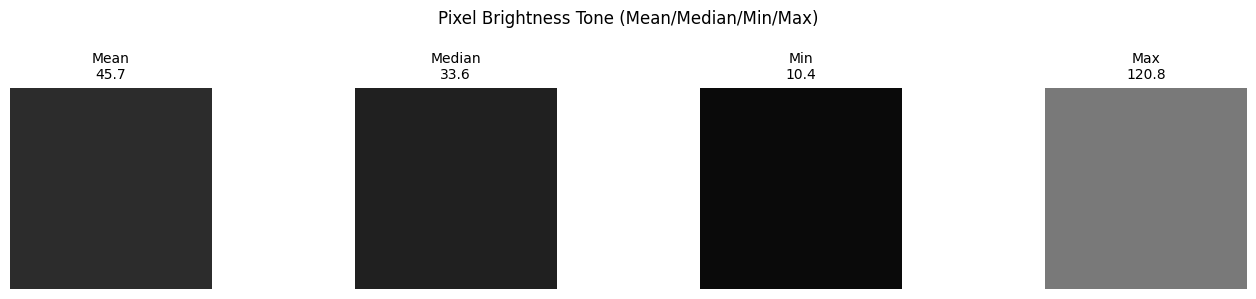

In [10]:
# ----------------------------------------------------------
# 3) 밝기 통계(Mean/Median/Min/Max)를 회색 Tone으로 표시
#    (Std는 톤으로 표현해도 직관성이 떨어져서 제외)
# ----------------------------------------------------------
values = [
    brightness_np.mean(),
    np.median(brightness_np),
    brightness_np.min(),
    brightness_np.max()
]
labels = ["Mean", "Median", "Min", "Max"]

plt.figure(figsize=(14, 3))  # 톤 이미지를 좀 더 크게
for i, val in enumerate(values):
    gray = float(val) / 255.0  # 0~1 정규화
    ax = plt.subplot(1, len(values), i + 1)
    ax.imshow([[gray]], cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"{labels[i]}\n{val:.1f}", fontsize=10)
    ax.axis("off")

plt.suptitle("Pixel Brightness Tone (Mean/Median/Min/Max)", fontsize=12)
plt.tight_layout()
plt.show()

### 2. DeepLabV3(ResNet50) 성능 파악
##### 동일한 backbone(ResNet 50)을 기준으로 성능이 좋은 모델 선택

In [13]:
import os, random
import numpy as np
import torch
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset

class COCOSemSeg(Dataset):
    """
    COCO instance/pixel annotations -> semantic mask (H,W) with train ids.
    공정 비교(DeepLabV3+ vs U-Net, backbone=ResNet50)를 위해:
      - 동일한 resize
      - 동일한 normalize(외부 주입 가능)
      - train에만 augmentation
    """
    def __init__(
        self,
        coco,                 # COCO object
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512, 512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        priority_order=None,   # 예: [Undrivable, Moveable, ...] 처럼 "위험 우선" 덮어쓰기 순서 지정 가능
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.hflip_p = hflip_p

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        # priority_order가 들어오면 category_id 기준으로 덮어쓰기 우선순위를 정함
        # (기본 None이면 기존처럼 COCO anns 순서대로 덮어쓰기)
        self.priority_order = priority_order
        if self.priority_order is not None:
            # priority_order는 category_id 리스트라고 가정
            self._prio_rank = {cid: i for i, cid in enumerate(self.priority_order)}

    def __len__(self):
        return len(self.img_ids)

    def _build_mask(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        # (옵션) 위험 우선순위 덮어쓰기: priority_order 앞쪽/뒤쪽 중 무엇이 우선인지 실험 가능
        if self.priority_order is not None:
            # rank가 작은 것부터 먼저 칠하고, rank 큰 것이 마지막에 덮어쓰도록(=우선)
            anns = sorted(
                anns,
                key=lambda a: self._prio_rank.get(a["category_id"], -1)
            )

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]

        return mask

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, img_info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size

        mask = self._build_mask(img_id, H, W)
        mask = Image.fromarray(mask)

        # ---- 공정 비교를 위한 동일 resize ----
        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)
        mask = TF.resize(mask, self.size, interpolation=Image.NEAREST)

        # ---- train에만 augmentation ----
        if self.train and random.random() < self.hflip_p:
            img = TF.hflip(img)
            mask = TF.hflip(mask)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [16]:
# ======================
# COCO 이미지 ID 무작위 분할 + SemSeg Dataset/DataLoader
# ======================

import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader

# ======================
# 재현성 설정
# ======================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

g = torch.Generator()
g.manual_seed(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ======================
# 이미지 폴더 경로
# ======================
IMG_DIR = os.path.join(DATA_ROOT, "images")

# ======================
# category_id → 학습용 class index 매핑 (background=0, classes=1..K)
# ======================
categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1  # background 포함

# (옵션) 학습 class index -> name (IoU 출력용)
train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

# ======================
# 이미지 ID 분할 (중요: rng.shuffle로 재현성 고정)
# ======================
all_img_ids = sorted(coco.getImgIds())
rng = random.Random(SEED)
rng.shuffle(all_img_ids)  # ✅ 전역 random.shuffle 대신 rng.shuffle 사용

n = len(all_img_ids)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_ids = all_img_ids[:n_train]
val_ids   = all_img_ids[n_train:n_train + n_val]
test_ids  = all_img_ids[n_train + n_val:]

# ======================
# Dataset 생성
# ======================
train_ds = COCOSemSeg(coco, IMG_DIR, train_ids, id2train, size=(512, 512), train=True)
val_ds   = COCOSemSeg(coco, IMG_DIR, val_ids,   id2train, size=(512, 512), train=False)

# ======================
# DataLoader 생성
# ======================
NUM_WORKERS = 0

# Windows/Jupyter 안정성: persistent_workers 조건부
persistent_ok = (NUM_WORKERS > 0 and os.name != "nt")

train_loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=persistent_ok
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
    worker_init_fn=seed_worker,
    generator=g,
    persistent_workers=persistent_ok
)

print("train/val/test:", len(train_ids), len(val_ids), len(test_ids))
print("NUM_CLASSES:", NUM_CLASSES)
print("classes:", [train2name[i] for i in range(1, NUM_CLASSES)])

train/val/test: 160 20 20
NUM_CLASSES: 7
classes: ['Undrivable', 'Road', 'Lane Mark', 'Moveable', 'My bike', 'Rider']


In [17]:
# =========================================
# 0) train index -> class name (공통)
# =========================================
train2name = {0: "background"}
for cat in categories:
    train_idx = id2train[cat["id"]]
    train2name[train_idx] = cat["name"]


# =========================================
# 1) 공통 유틸: 모델 출력(logits) 통일
#    - torchvision DeepLabV3: dict["out"]
#    - smp(Unet/DeepLabV3Plus): tensor
# =========================================
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out


# =========================================
# 2) 모델 생성 함수 (교체 가능 구조)
#    mode="deeplabv3_torchvision" (현재)
#    mode="unet_smp" / "deeplabv3plus_smp" (나중)
# =========================================
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def build_model(mode: str, num_classes: int, device: str,
                encoder_name: str = "resnet50", encoder_weights: str = "imagenet"):
    """
    mode:
      - "deeplabv3_torchvision": (ResNet50 backbone만 현실적으로 사용)
      - "unet_smp": EfficientNet/ResNet 등 encoder 자유
      - "deeplabv3plus_smp": EfficientNet/ResNet 등 encoder 자유

    encoder_name/encoder_weights는 smp 계열에서만 사용됨.
    """
    if mode == "deeplabv3_torchvision":
        # torchvision DeepLabV3: backbone=ResNet50 고정(공식 제공)
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
        return model.to(device)

    elif mode in ["unet_smp", "deeplabv3plus_smp"]:
        import segmentation_models_pytorch as smp

        if mode == "unet_smp":
            model = smp.Unet(
                encoder_name=encoder_name,        # 예: "efficientnet-b0", "resnet50"
                encoder_weights=encoder_weights,  # "imagenet" or None
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        else:
            model = smp.DeepLabV3Plus(
                encoder_name=encoder_name,
                encoder_weights=encoder_weights,
                in_channels=3,
                classes=num_classes,
                activation=None
            )
        return model.to(device)

    else:
        raise ValueError(f"Unknown mode: {mode}")


# =========================================
# 3) Optim/Loss 생성 함수 (공통)
#    - 어떤 모델로 바꿔도 동일하게 사용
# =========================================
def build_optim_and_loss(model, lr=3e-4, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer


# =========================================
# 4) 지금은 DeepLabV3(ResNet50)로 시작
# =========================================
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

MODEL_MODE = "deeplabv3_torchvision"  # ✅ 현재 baseline
model = build_model(MODEL_MODE, NUM_CLASSES, device=device)

criterion, optimizer = build_optim_and_loss(model, lr=3e-4, wd=1e-4)

print(f"model ready: {MODEL_MODE}")

device: cuda
model ready: deeplabv3_torchvision


In [18]:
import numpy as np
import torch

def _get_logits(model_out):
    """DeepLabV3(torchvision): dict['out'], U-Net(smp): tensor"""
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    """
    pred/target: (N,H,W) on CPU or GPU 상관없음 (여기선 CPU로 누적 추천)
    return: (C,C) confusion matrix (long)
    """
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    """
    conf: (C,C) long
    return: miou(float), per_class_iou(np.ndarray shape (C,))
    """
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou


def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))          # ✅ DeepLab/UNet 공용
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)


@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))          # ✅ DeepLab/UNet 공용
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)                # (N,H,W) on GPU
        # confusion 누적은 CPU로 (메모리/속도 안정)
        conf += _confusion_from_pred(pred.detach().cpu(), masks.detach().cpu(),
                                     num_classes=num_classes, ignore_index=ignore_index)

    val_loss = total_loss / len(loader.dataset)
    val_miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # 기존 출력 형식(per_class dict) 유지하고 싶으면
    per_class_mean = {cls: float(per_class_iou[cls]) for cls in range(num_classes)}

    return val_loss, val_miou, per_class_mean

In [23]:
import os
import numpy as np
import torch

# =========================
# CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3
MODEL_NAME = "baseline_deeplabv3_resnet50.pth"
HISTORY_NAME = "history_deeplabv3_resnet50.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# per-class 형태 통일 유틸
# =========================
def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes

    if isinstance(per_class, dict):
        for c in range(num_classes):
            if c in per_class:
                v = per_class[c]
                out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
        return out

    if isinstance(per_class, (list, tuple, np.ndarray)):
        L = min(len(per_class), num_classes)
        for c in range(L):
            v = per_class[c]
            out[c] = float(v) if v is not None and np.isfinite(v) else np.nan
        return out

    return out

# =========================
# history 버퍼
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# TRAIN LOOP
# =========================
for epoch in range(1, EPOCHS + 1):

    # ---- train ----
    tr_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )

    # ---- validate ----
    va_loss, va_miou, per_class = validate(
        model,
        val_loader,
        criterion,
        device,
        NUM_CLASSES,
        exclude_background=True
    )

    per_class_list = to_per_class_list(per_class, NUM_CLASSES)

    # ---- 출력 ----
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")

    for cls in range(1, NUM_CLASSES):
        cls_name = train2name.get(cls, f"class_{cls}")
        iou = per_class_list[cls]
        print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

    # ---- history 저장 ----
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["per_class_iou"].append(
        [float(x) if np.isfinite(x) else np.nan for x in per_class_list]
    )

    # ---- best model + early stopping ----
    if va_miou > best_miou:
        best_miou = va_miou
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved: {MODEL_NAME} (best mIoU={best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping at epoch {epoch}")
        print(f"Best mIoU: {best_miou:.4f}")
        break

# =========================
# history 저장
# =========================
try:
    np.savez(
        HISTORY_NAME,
        epoch=np.array(history["epoch"], dtype=np.int32),
        train_loss=np.array(history["train_loss"], dtype=np.float32),
        val_loss=np.array(history["val_loss"], dtype=np.float32),
        val_miou=np.array(history["val_miou"], dtype=np.float32),
        per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
    )
    print(f"\n✅ history saved: {HISTORY_NAME}")
except Exception as e:
    print(f"\n⚠ history save skipped: {e}")

[01/30] train_loss=0.5142 | val_loss=0.3607 | mIoU=0.6430
  IoU Undrivable: 0.8813
  IoU Road      : 0.7326
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6298
  IoU My bike   : 0.8547
  IoU Rider     : 0.7595
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.6430)
[02/30] train_loss=0.2504 | val_loss=0.2449 | mIoU=0.6996
  IoU Undrivable: 0.9053
  IoU Road      : 0.8007
  IoU Lane Mark : 0.0194
  IoU Moveable  : 0.6863
  IoU My bike   : 0.9192
  IoU Rider     : 0.8665
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.6996)
[03/30] train_loss=0.1888 | val_loss=0.2350 | mIoU=0.7153
  IoU Undrivable: 0.9054
  IoU Road      : 0.8032
  IoU Lane Mark : 0.0849
  IoU Moveable  : 0.7076
  IoU My bike   : 0.9247
  IoU Rider     : 0.8659
  ✅ saved: baseline_deeplabv3_resnet50.pth (best mIoU=0.7153)
[04/30] train_loss=0.1568 | val_loss=0.2296 | mIoU=0.7305
  IoU Undrivable: 0.9095
  IoU Road      : 0.8158
  IoU Lane Mark : 0.1004
  IoU Moveable  : 0.7445
  IoU My bike   : 0.9270
  IoU R

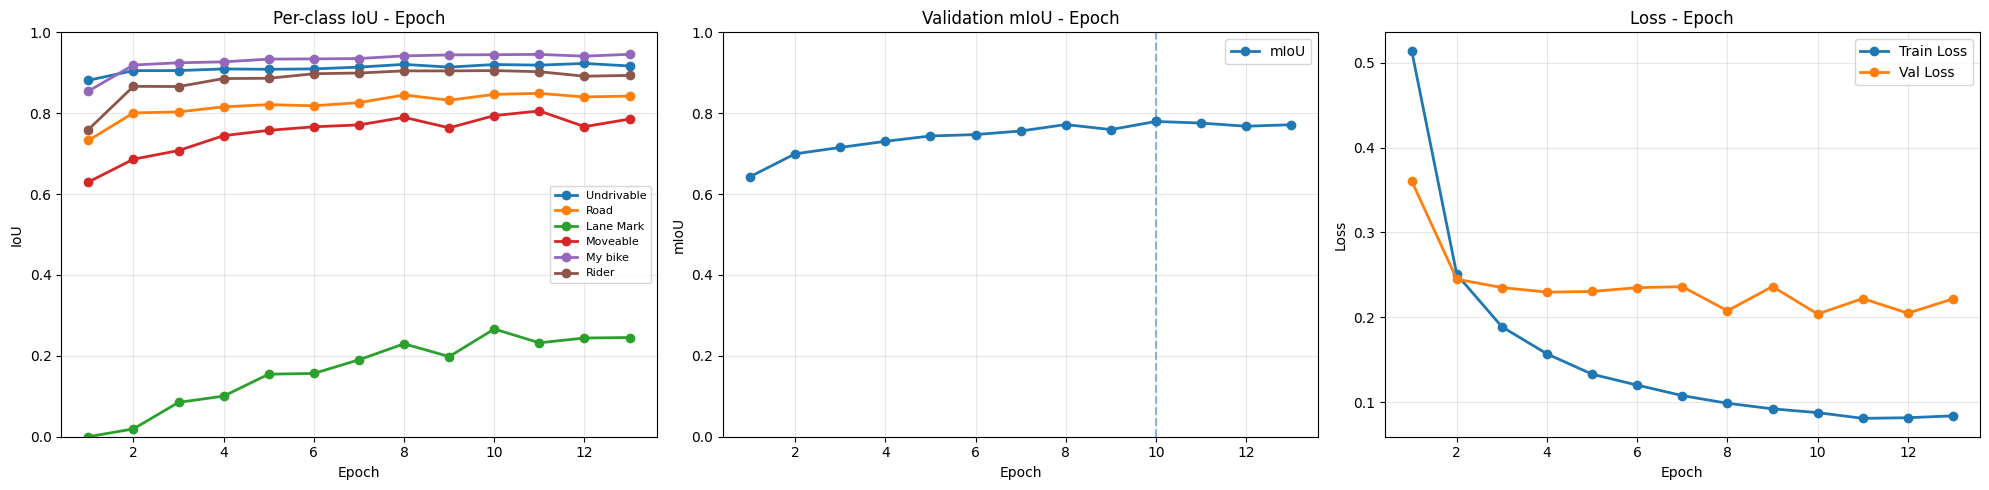

In [24]:
import numpy as np
import matplotlib.pyplot as plt

epochs = history["epoch"]
per_class = np.array(history["per_class_iou"])

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# ======================
# ① Per-class IoU
# ======================
ax = axes[0]

for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")
    ax.plot(
        epochs,
        per_class[:, cls],
        marker="o",
        linewidth=2,
        label=name
    )

ax.set_title("Per-class IoU - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("IoU")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=8)


# ======================
# ② mIoU
# ======================
ax = axes[1]

ax.plot(
    history["epoch"],
    history["val_miou"],
    marker="o",
    linewidth=2,
    label="mIoU"
)

best_epoch = history["epoch"][np.argmax(history["val_miou"])]
best_miou  = max(history["val_miou"])

ax.axvline(best_epoch, linestyle="--", alpha=0.5)
ax.scatter(best_epoch, best_miou, zorder=5)

ax.set_title("Validation mIoU - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("mIoU")
ax.set_ylim(0, 1.0)
ax.grid(True, alpha=0.3)
ax.legend()


# ======================
# ③ Loss 그래프
# ======================
ax = axes[2]

ax.plot(
    history["epoch"],
    history["train_loss"],
    marker="o",
    linewidth=2,
    label="Train Loss"
)

ax.plot(
    history["epoch"],
    history["val_loss"],
    marker="o",
    linewidth=2,
    label="Val Loss"
)

ax.set_title("Loss - Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.grid(True, alpha=0.3)
ax.legend()


plt.tight_layout()
plt.show()

🔥 Worst sample idxs: [5, 17]
idx=5 | pixel_acc=0.7952


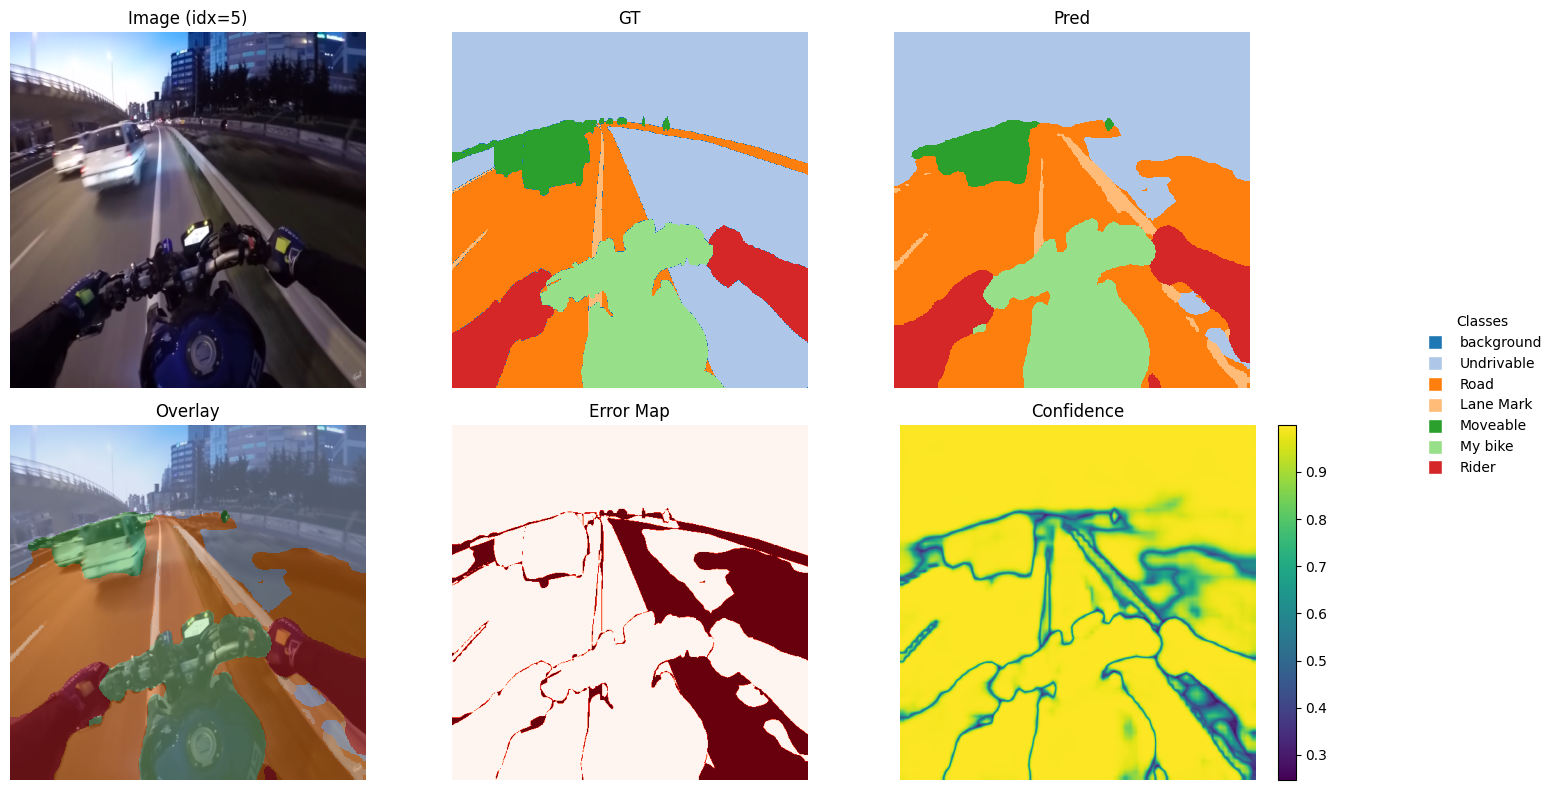

idx=17 | pixel_acc=0.8276


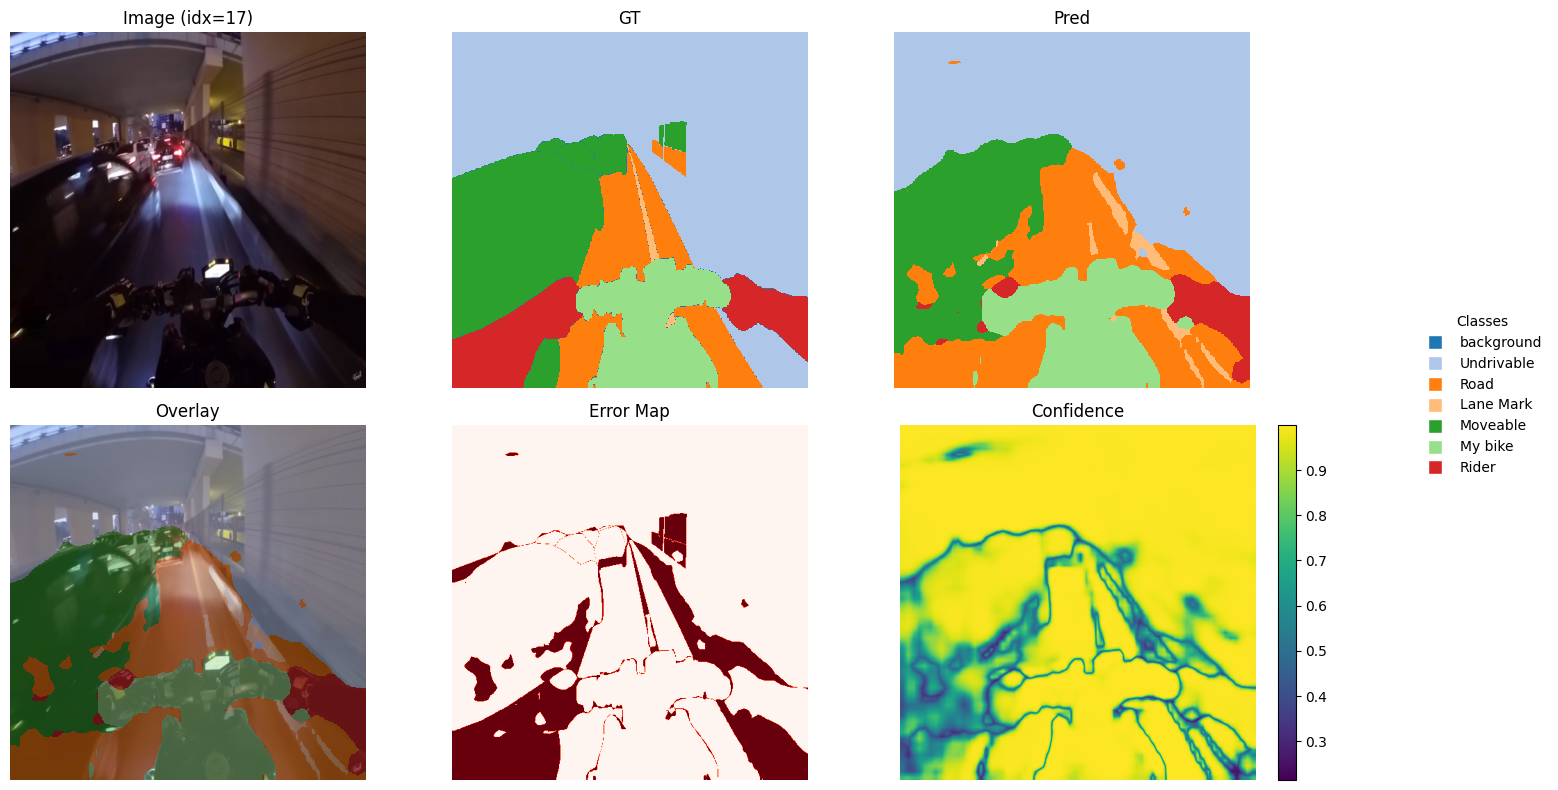

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch

# -----------------------------
# 1) logits 추출 (DeepLab(dict) / UNet(tensor) 모두 대응)
# -----------------------------
def get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# -----------------------------
# 2) 단일 샘플 시각화 (Image / GT / Pred / Overlay / Error / Conf)
# -----------------------------
@torch.no_grad()
def show_pred(model, dataset, idx=0, alpha=0.5):
    model.eval()

    img, mask = dataset[idx]              # img: (3,H,W), mask: (H,W)
    x = img.unsqueeze(0).to(device)

    logits = get_logits(model(x))[0]      # (C,H,W)
    prob = torch.softmax(logits, dim=0)   # (C,H,W)

    pred = prob.argmax(0).cpu().numpy()  # (H,W)
    conf = prob.max(0)[0].cpu().numpy()  # (H,W)
    gt   = mask.cpu().numpy()

    # denorm image
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img_np = img.permute(1,2,0).cpu().numpy()
    img_np = (img_np * std + mean).clip(0, 1)

    # colormap
    base_cmap = plt.get_cmap("tab20")
    cmap = ListedColormap(base_cmap.colors[:NUM_CLASSES])

    # error map
    error_map = (pred != gt)

    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    axes[0,0].imshow(img_np); axes[0,0].set_title(f"Image (idx={idx})"); axes[0,0].axis("off")
    axes[0,1].imshow(gt,   cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, interpolation="nearest"); axes[0,1].set_title("GT"); axes[0,1].axis("off")
    axes[0,2].imshow(pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, interpolation="nearest"); axes[0,2].set_title("Pred"); axes[0,2].axis("off")

    axes[1,0].imshow(img_np)
    axes[1,0].imshow(pred, cmap=cmap, vmin=0, vmax=NUM_CLASSES-1, alpha=alpha, interpolation="nearest")
    axes[1,0].set_title("Overlay"); axes[1,0].axis("off")

    axes[1,1].imshow(error_map, cmap="Reds")
    axes[1,1].set_title("Error Map"); axes[1,1].axis("off")

    im = axes[1,2].imshow(conf, cmap="viridis")
    axes[1,2].set_title("Confidence"); axes[1,2].axis("off")
    fig.colorbar(im, ax=axes[1,2], fraction=0.046)

    # legend
    handles, labels = [], []
    for cls in range(NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        handles.append(plt.Line2D([0],[0], marker='s', color='w',
                                  markerfacecolor=cmap(cls), markersize=10))
        labels.append(name)

    fig.legend(handles, labels, loc="center right", bbox_to_anchor=(1.15, 0.5),
               frameon=False, title="Classes")

    plt.tight_layout()
    plt.show()

# -----------------------------
# 3) Worst-k (기본 2개만)
# -----------------------------
@torch.no_grad()
def worst_k_visualize(model, dataset, k=2, max_scan=None):
    model.eval()
    scores = []

    N = len(dataset) if max_scan is None else min(len(dataset), max_scan)

    for i in range(N):
        img_t, gt = dataset[i]
        x = img_t.unsqueeze(0).to(device)

        logits = get_logits(model(x))
        pred = logits.argmax(1).squeeze(0).detach().cpu().numpy()
        gt_np = gt.detach().cpu().numpy()

        acc = (pred == gt_np).mean()
        scores.append((acc, i))

    scores.sort(key=lambda x: x[0])  # 낮은 acc 순
    worst_idxs = [i for _, i in scores[:k]]

    print("🔥 Worst sample idxs:", worst_idxs)

    for idx in worst_idxs:
        # 간단 점수 출력(필요 없으면 지워도 됨)
        img_t, gt = dataset[idx]
        x = img_t.unsqueeze(0).to(device)
        logits = get_logits(model(x))
        pred = logits.argmax(1).squeeze(0).detach().cpu().numpy()
        acc = (pred == gt.detach().cpu().numpy()).mean()
        print(f"idx={idx} | pixel_acc={acc:.4f}")

        show_pred(model, dataset, idx=idx, alpha=0.45)

# 실행
worst_k_visualize(model, val_ds, k=2)

### Test

In [27]:
import numpy as np
import torch
from torch.utils.data import DataLoader

# ======================
# Test Dataset / Loader
# ======================
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,  # ✅ 로컬/주피터에서 안전
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# ======================
# Best Model Load
# ======================
BEST_PATH = "baseline_deeplabv3_resnet50.pth"  # 저장한 파일명
state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.to(device)
model.eval()
print("✅ loaded best:", BEST_PATH)

# ======================
# Test Evaluate  (✅ validate 시그니처 맞춤)
# ======================
test_loss, test_miou, test_per_class = validate(
    model, test_loader,
    criterion, device, NUM_CLASSES
)

print("\n===== TEST BENCHMARK =====")
print(f"test_loss = {float(test_loss):.4f}")
print(f"test_mIoU = {float(test_miou):.4f}")

# ----------------------
# per-class IoU 출력 (dict/list 둘 다 대응)
# ----------------------
if isinstance(test_per_class, dict):
    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        v = test_per_class.get(cls, float("nan"))
        if np.isfinite(v):
            print(f"  IoU {name:10s}: {float(v):.4f}")
        else:
            print(f"  IoU {name:10s}: nan")
else:
    arr = np.array(test_per_class, dtype=np.float32)
    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        v = arr[cls] if cls < len(arr) else np.nan
        if np.isfinite(v):
            print(f"  IoU {name:10s}: {float(v):.4f}")
        else:
            print(f"  IoU {name:10s}: nan")

test: 20
✅ loaded best: baseline_deeplabv3_resnet50.pth

===== TEST BENCHMARK =====
test_loss = 0.1512
test_mIoU = 0.8189
  IoU Undrivable: 0.9478
  IoU Road      : 0.8863
  IoU Lane Mark : 0.4931
  IoU Moveable  : 0.7073
  IoU My bike   : 0.9474
  IoU Rider     : 0.9314


### 3. U-Net(Backbone ResNet 50) 성능 파악

In [29]:
# --- UNet(ResNet encoder) 모델만 교체 ---
import torch.nn as nn

try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("pip install segmentation-models-pytorch 로 설치 후 진행하세요.")

# UNet + ResNet50 encoder (ImageNet pretrained)
core = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None,
)

# smp는 logits만 반환 → torchvision처럼 {"out": logits}로 래핑
class Wrap(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = Wrap(core).to(device)

In [30]:
@torch.no_grad()
def compute_iou(pred, target, num_classes):
    # pred/target: (N,H,W)
    ious = []
    per_class = {}
    for cls in range(num_classes):
        pred_i = (pred == cls)
        targ_i = (target == cls)
        inter = (pred_i & targ_i).sum().item()
        union = (pred_i | targ_i).sum().item()
        if union == 0:
            iou = float("nan")
        else:
            iou = inter / union
        per_class[cls] = iou
        ious.append(iou)
    # mean over valid classes
    valid = [x for x in ious if not (isinstance(x, float) and np.isnan(x))]
    miou = float(np.mean(valid)) if len(valid) else 0.0
    return miou, per_class

In [31]:
import torch
import numpy as np
from tqdm.auto import tqdm

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes, ignore_index=None):
    model.eval()
    total_loss = 0.0

    # confusion matrix: [num_classes, num_classes]
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)

    for imgs, masks in tqdm(loader, desc="val", leave=False):
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = model(imgs)["out"]              # (N,C,H,W)
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        preds = logits.argmax(dim=1)             # (N,H,W)

        # flatten
        preds = preds.view(-1).detach().cpu()
        gts   = masks.view(-1).detach().cpu()

        if ignore_index is not None:
            keep = (gts != ignore_index)
            preds = preds[keep]
            gts   = gts[keep]

        k = (gts >= 0) & (gts < num_classes)
        inds = num_classes * gts[k] + preds[k]
        conf += torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)

    # IoU 계산
    tp = conf.diag().float()
    fp = conf.sum(0).float() - tp
    fn = conf.sum(1).float() - tp
    denom = tp + fp + fn

    per_class_iou = (tp / torch.clamp(denom, min=1.0)).numpy()  # shape: [C]
    # background(0) 제외 mIoU (원하면 포함/제외 변경 가능)
    miou = float(np.nanmean(per_class_iou[1:]))

    # dict 형태로도 반환(기존 코드 호환)
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}

    val_loss = total_loss / len(loader.dataset)
    return val_loss, miou, per_class_dict

In [32]:
# =========================================================
# UNet(ResNet50 encoder) + 학습 루프 (인자형 train/validate 대응)  ✅수정본
# =========================================================

import numpy as np
import torch
import torch.nn as nn

# =========================
# 0) UNet 모델 정의 (ResNet50 encoder)
# =========================
try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("segmentation_models_pytorch 필요: pip install segmentation-models-pytorch")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

core_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    """smp는 Tensor(logits) 반환 → torchvision처럼 {'out': logits}로 맞춤"""
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = WrapOut(core_unet).to(device)

# =========================
# 1) Loss / Optimizer 재생성 (필수)
# =========================
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# sanity check (옵티마이저가 현재 모델 파라미터 잡는지)
model_param_ids = set(id(p) for p in model.parameters())
opt_param_ids = set(id(p) for g in optimizer.param_groups for p in g["params"])
assert len(model_param_ids & opt_param_ids) > 0, "❌ optimizer가 UNet 파라미터를 안 잡고 있습니다."
print("✅ UNet ready")

# =========================
# 2) CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3
MODEL_NAME = "baseline_unet_resnet50.pth"
HISTORY_NAME = "history_unet_resnet50.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# 3) per_class 정리 유틸 (dict/list/np 모두 대응)
# =========================
def to_per_class_list(per_class, num_classes: int):
    out = [np.nan] * num_classes

    if isinstance(per_class, dict):
        for c in range(num_classes):
            try:
                v = float(per_class.get(c, np.nan))
                out[c] = v if np.isfinite(v) else np.nan
            except:
                out[c] = np.nan
        return out

    if isinstance(per_class, (list, tuple, np.ndarray)):
        L = min(len(per_class), num_classes)
        for c in range(L):
            try:
                v = float(per_class[c])
                out[c] = v if np.isfinite(v) else np.nan
            except:
                out[c] = np.nan
        return out

    return out

# =========================
# 4) history
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []   # epoch마다 길이 NUM_CLASSES 리스트
}

# =========================
# 5) TRAIN LOOP
#   - train_one_epoch(model, loader, criterion, optimizer, device)
#   - validate(model, loader, criterion, device, num_classes, ignore_index=None)
# =========================
for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # ✅ validate는 confusion-matrix 누적형(추천)
    va_loss, va_miou, per_class = validate(
        model, val_loader,
        criterion=criterion,
        device=device,
        num_classes=NUM_CLASSES,
        ignore_index=None
    )

    per_class_list = to_per_class_list(per_class, NUM_CLASSES)

    print(f"[UNet] [{epoch:02d}/{EPOCHS}] "
          f"train_loss={float(tr_loss):.4f} | val_loss={float(va_loss):.4f} | mIoU={float(va_miou):.4f}")

    for cls in range(1, NUM_CLASSES):  # background(0) 제외 출력
        cls_name = train2name.get(cls, str(cls)) if isinstance(train2name, dict) else str(cls)
        iou = per_class_list[cls]
        print(f"  IoU {cls_name:10s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

    # history 저장
    history["epoch"].append(int(epoch))
    history["train_loss"].append(float(tr_loss))
    history["val_loss"].append(float(va_loss))
    history["val_miou"].append(float(va_miou))
    history["per_class_iou"].append([float(x) if np.isfinite(x) else np.nan for x in per_class_list])

    # best + early stopping
    if float(va_miou) > float(best_miou):
        best_miou = float(va_miou)
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved: {MODEL_NAME} (best_mIoU={best_miou:.4f})")
    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE}) | best_mIoU={best_miou:.4f}")

    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered at epoch {epoch}")
        print(f"Best mIoU: {best_miou:.4f}")
        break

# =========================
# 6) history 저장
# =========================
np.savez(
    HISTORY_NAME,
    epoch=np.array(history["epoch"], dtype=np.int32),
    train_loss=np.array(history["train_loss"], dtype=np.float32),
    val_loss=np.array(history["val_loss"], dtype=np.float32),
    val_miou=np.array(history["val_miou"], dtype=np.float32),
    per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
)
print(f"\n✅ history saved: {HISTORY_NAME}")

device: cuda
✅ UNet ready


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [01/30] train_loss=1.1174 | val_loss=0.7797 | mIoU=0.4749
  IoU Undrivable: 0.8035
  IoU Road      : 0.6950
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.0019
  IoU My bike   : 0.7899
  IoU Rider     : 0.5588
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.4749)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [02/30] train_loss=0.5383 | val_loss=0.4843 | mIoU=0.5355
  IoU Undrivable: 0.8212
  IoU Road      : 0.7881
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.0002
  IoU My bike   : 0.8378
  IoU Rider     : 0.7656
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.5355)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [03/30] train_loss=0.3868 | val_loss=0.4129 | mIoU=0.6084
  IoU Undrivable: 0.8415
  IoU Road      : 0.7937
  IoU Lane Mark : 0.0001
  IoU Moveable  : 0.3424
  IoU My bike   : 0.8916
  IoU Rider     : 0.7811
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6084)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [04/30] train_loss=0.3187 | val_loss=0.3965 | mIoU=0.6363
  IoU Undrivable: 0.8609
  IoU Road      : 0.8005
  IoU Lane Mark : 0.0002
  IoU Moveable  : 0.5159
  IoU My bike   : 0.8143
  IoU Rider     : 0.8260
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6363)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [05/30] train_loss=0.2895 | val_loss=0.4768 | mIoU=0.5866
  IoU Undrivable: 0.8150
  IoU Road      : 0.7767
  IoU Lane Mark : 0.0009
  IoU Moveable  : 0.3802
  IoU My bike   : 0.8349
  IoU Rider     : 0.7123
  ⏸ no improvement (1/3) | best_mIoU=0.6363


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [06/30] train_loss=0.2790 | val_loss=0.3808 | mIoU=0.6466
  IoU Undrivable: 0.8476
  IoU Road      : 0.7916
  IoU Lane Mark : 0.0015
  IoU Moveable  : 0.5309
  IoU My bike   : 0.8780
  IoU Rider     : 0.8301
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6466)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [07/30] train_loss=0.2351 | val_loss=0.3359 | mIoU=0.6668
  IoU Undrivable: 0.8600
  IoU Road      : 0.7961
  IoU Lane Mark : 0.0162
  IoU Moveable  : 0.5505
  IoU My bike   : 0.9119
  IoU Rider     : 0.8660
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6668)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [08/30] train_loss=0.2153 | val_loss=0.3320 | mIoU=0.6749
  IoU Undrivable: 0.8693
  IoU Road      : 0.8022
  IoU Lane Mark : 0.0391
  IoU Moveable  : 0.6352
  IoU My bike   : 0.8741
  IoU Rider     : 0.8293
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.6749)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [09/30] train_loss=0.2014 | val_loss=0.2946 | mIoU=0.7088
  IoU Undrivable: 0.8757
  IoU Road      : 0.8039
  IoU Lane Mark : 0.0907
  IoU Moveable  : 0.7101
  IoU My bike   : 0.9105
  IoU Rider     : 0.8621
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7088)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [10/30] train_loss=0.1849 | val_loss=0.3301 | mIoU=0.6976
  IoU Undrivable: 0.8824
  IoU Road      : 0.8226
  IoU Lane Mark : 0.2198
  IoU Moveable  : 0.5734
  IoU My bike   : 0.8606
  IoU Rider     : 0.8269
  ⏸ no improvement (1/3) | best_mIoU=0.7088


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [11/30] train_loss=0.1741 | val_loss=0.2911 | mIoU=0.7322
  IoU Undrivable: 0.8796
  IoU Road      : 0.8235
  IoU Lane Mark : 0.2369
  IoU Moveable  : 0.6803
  IoU My bike   : 0.8902
  IoU Rider     : 0.8830
  ✅ saved: baseline_unet_resnet50.pth (best_mIoU=0.7322)


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [12/30] train_loss=0.1872 | val_loss=0.2868 | mIoU=0.7161
  IoU Undrivable: 0.8892
  IoU Road      : 0.8331
  IoU Lane Mark : 0.2657
  IoU Moveable  : 0.6187
  IoU My bike   : 0.9051
  IoU Rider     : 0.7850
  ⏸ no improvement (1/3) | best_mIoU=0.7322


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [13/30] train_loss=0.1699 | val_loss=0.3242 | mIoU=0.7220
  IoU Undrivable: 0.8629
  IoU Road      : 0.8025
  IoU Lane Mark : 0.2572
  IoU Moveable  : 0.6001
  IoU My bike   : 0.9365
  IoU Rider     : 0.8728
  ⏸ no improvement (2/3) | best_mIoU=0.7322


val:   0%|          | 0/5 [00:00<?, ?it/s]

[UNet] [14/30] train_loss=0.1556 | val_loss=0.3312 | mIoU=0.7242
  IoU Undrivable: 0.8709
  IoU Road      : 0.8217
  IoU Lane Mark : 0.2737
  IoU Moveable  : 0.5981
  IoU My bike   : 0.9202
  IoU Rider     : 0.8606
  ⏸ no improvement (3/3) | best_mIoU=0.7322

🛑 Early stopping triggered at epoch 14
Best mIoU: 0.7322

✅ history saved: history_unet_resnet50.npz


### U-Net Test

In [34]:
# =========================================================
# UNet TEST BENCHMARK  ✅복붙용 수정본
# =========================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ======================
# 0) device
# ======================
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ======================
# 1) Test Dataset / Loader
# ======================
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

# ✅ NUM_WORKERS=0이면 아래 옵션들( worker_init_fn / generator / persistent_workers ) 제거
test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# ======================
# 2) UNet 모델 재구성 + 로드
# ======================
try:
    import segmentation_models_pytorch as smp
except ImportError:
    raise ImportError("segmentation_models_pytorch 필요: pip install segmentation-models-pytorch")

core_unet = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    """smp는 Tensor(logits) 반환 → torchvision처럼 {'out': logits}로 맞춤"""
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

model = WrapOut(core_unet).to(device)

# ======================
# 3) Loss (validate에서 필요)
# ======================
criterion = nn.CrossEntropyLoss()

# ======================
# 4) best weight 로드
# ======================
BEST_PATH = "baseline_unet_resnet50.pth"   # ✅ UNet best 파일
state = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("✅ loaded best:", BEST_PATH)

# ======================
# 5) TEST 실행 (인자형 validate 호출)
# ======================
test_loss, test_miou, test_per_class = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=NUM_CLASSES,
    ignore_index=None
)

print("\n===== UNet TEST BENCHMARK =====")
print(f"test_loss = {float(test_loss):.4f}")
print(f"test_mIoU = {float(test_miou):.4f}")

# test_per_class는 dict 형태(권장) / list 형태 둘 다 대응
for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")

    if isinstance(test_per_class, dict):
        v = float(test_per_class.get(cls, np.nan))
    else:
        v = float(test_per_class[cls]) if cls < len(test_per_class) else np.nan

    print(f"  IoU {name:10s}: {'nan' if np.isnan(v) else f'{v:.4f}'}")


device: cuda
test: 20
✅ loaded best: baseline_unet_resnet50.pth


val:   0%|          | 0/5 [00:00<?, ?it/s]


===== UNet TEST BENCHMARK =====
test_loss = 0.2171
test_mIoU = 0.7554
  IoU Undrivable: 0.9165
  IoU Road      : 0.8591
  IoU Lane Mark : 0.3749
  IoU Moveable  : 0.5482
  IoU My bike   : 0.9231
  IoU Rider     : 0.9106


### Baseline 결정
#### 1) Test 결과 비교(총 3회 시행)
---
- 총 3회 반복하여 테스트한 결과 3회 모두 Deeplab v3 U-Net 보다 우수함
- 특히 가장 좋은 성능간 비교를 기준으로 양자의 차이를 비교하면 아래와 같음
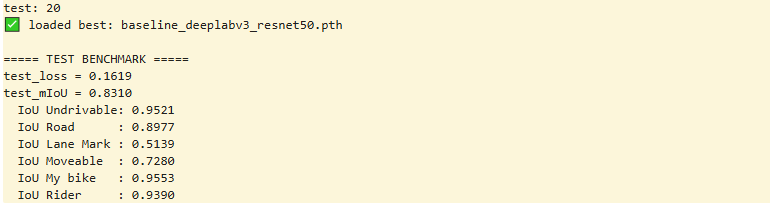

##### mIoU
- UNet: 0.7988
- DeepLabV3: 0.8310 
- → DeepLabV3 +0.0322p( 우세)
  
#### test_loss
- UNet: 0.1693
- DeepLabV3: 0.1619 → DeepLab이 더 낮음(좋음)

##### Lane Mark IoU 
- DeepLab: 0.5139
- UNet: 0.4196
- → +0.0943 Deeplab 우세

#### 클래스별 IoU 비교 (DeepLab이 전부 우세)
- Undrivable: 0.9397 → 0.9521 (+0.0124)
- Road: 0.8834 → 0.8977 (+0.0143)
- Lane Mark: 0.4196 → 0.5139 (+0.0943) 
- Moveable: 0.6696 → 0.7280 (+0.0584)
- My bike: 0.9525 → 0.9553 (+0.0028)
- Rider: 0.9279 → 0.9390 (+0.0111)

### 2) 베이스라인 결정
- 2. Base Line 모델 결정: DeepLabV3-ResNet50 확정

### 4 Deeplab v3 (Backbone EffientNet-B3) 성능

In [37]:
# =========================================================
# DeepLabV3 (EfficientNet-B3 encoder) - model 생성 
# - 존 train_one_epoch / validate / 시각화 / test 코드 그대로 재사용
# - 핵심: smp 모델(Tensor logits)을 torchvision처럼 {"out": logits}로 래핑
# =========================================================

import torch
import torch.nn as nn

import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# ---- DeepLabV3 with EfficientNet-B3 encoder ----
core = smp.DeepLabV3(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
)

class WrapOut(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}  # torchvision 호환

model = WrapOut(core).to(device)
print("✅ model ready:", type(model))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

# sanity check
model_param_ids = set(id(p) for p in model.parameters())
opt_param_ids = set(id(p) for g in optimizer.param_groups for p in g["params"])
assert len(model_param_ids & opt_param_ids) > 0, "❌ optimizer가 현재 model 파라미터를 안 잡고 있습니다."

print("✅ optimizer ok")

device: cuda
✅ model ready: <class '__main__.WrapOut'>
✅ optimizer ok


In [38]:
import numpy as np
import torch

# ---------------------------------
# 1) 모델 출력(logits) 통일
#   - torchvision: dict["out"]
#   - smp: Tensor
# ---------------------------------
def _get_logits(model_out):
    if isinstance(model_out, dict):
        return model_out["out"]
    return model_out

# ---------------------------------
# 2) confusion matrix 누적
# ---------------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background: bool = True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn

    iou = tp / torch.clamp(denom, min=1.0)  # (C,)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

# ---------------------------------
# 3) train / validate (✅ exclude_background 지원)
# ---------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))        # (N,C,H,W)
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background: bool = True, ignore_index=None):
    model.eval()
    total_loss = 0.0

    # CPU 누적
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))        # (N,C,H,W)
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)              # (N,H,W)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    val_loss = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)

    # 기존 코드 호환: dict로 반환
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}
    return val_loss, miou, per_class_dict

va_loss, va_miou, per_class = validate(
    model, val_loader, criterion, device, NUM_CLASSES,
    exclude_background=True
)

In [39]:
import os
import numpy as np
import torch

# =========================
# CONFIG
# =========================
EPOCHS = 30
PATIENCE = 3

MODEL_NAME = "deeplabv3_effb3_best.pth"
HISTORY_NAME = "deeplabv3_effb3_history.npz"

best_miou = -1.0
patience_counter = 0

# =========================
# history buffer
# =========================
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "per_class_iou": []
}

# =========================
# TRAIN LOOP
# =========================
for epoch in range(1, EPOCHS + 1):

    # ----- train -----
    tr_loss = train_one_epoch(
        model,
        train_loader,
        criterion,
        optimizer,
        device
    )

    # ----- validate -----
    va_loss, va_miou, per_class = validate(
        model,
        val_loader,
        criterion,
        device,
        NUM_CLASSES,
        exclude_background=True
    )

    # ---- 출력 ----
    print(f"[{epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | mIoU={va_miou:.4f}")

    for cls in range(1, NUM_CLASSES):
        name = train2name.get(cls, f"class_{cls}")
        print(f"  IoU {name:10s}: {per_class[cls]:.4f}")

    # ---- history 저장 ----
    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["per_class_iou"].append(
        [per_class[c] for c in range(NUM_CLASSES)]
    )

    # ---- best model ----
    if va_miou > best_miou:
        best_miou = va_miou
        patience_counter = 0
        torch.save(model.state_dict(), MODEL_NAME)
        print(f"  ✅ saved best model ({best_miou:.4f})")

    else:
        patience_counter += 1
        print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

    if patience_counter >= PATIENCE:
        print("🛑 Early stopping triggered")
        break

# =========================
# history 저장
# =========================
np.savez(
    HISTORY_NAME,
    epoch=np.array(history["epoch"]),
    train_loss=np.array(history["train_loss"]),
    val_loss=np.array(history["val_loss"]),
    val_miou=np.array(history["val_miou"]),
    per_class_iou=np.array(history["per_class_iou"])
)

print("✅ history saved")

[01/30] train_loss=0.6405 | val_loss=0.4741 | mIoU=0.5972
  IoU Undrivable: 0.8518
  IoU Road      : 0.6634
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.5344
  IoU My bike   : 0.8026
  IoU Rider     : 0.7308
  ✅ saved best model (0.5972)
[02/30] train_loss=0.3380 | val_loss=0.3491 | mIoU=0.6462
  IoU Undrivable: 0.8782
  IoU Road      : 0.7267
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6497
  IoU My bike   : 0.8255
  IoU Rider     : 0.7969
  ✅ saved best model (0.6462)
[03/30] train_loss=0.2739 | val_loss=0.3226 | mIoU=0.6640
  IoU Undrivable: 0.8794
  IoU Road      : 0.7410
  IoU Lane Mark : 0.0000
  IoU Moveable  : 0.6725
  IoU My bike   : 0.8609
  IoU Rider     : 0.8299
  ✅ saved best model (0.6640)
[04/30] train_loss=0.2377 | val_loss=0.2721 | mIoU=0.6914
  IoU Undrivable: 0.8866
  IoU Road      : 0.7781
  IoU Lane Mark : 0.0001
  IoU Moveable  : 0.7249
  IoU My bike   : 0.8960
  IoU Rider     : 0.8630
  ✅ saved best model (0.6914)
[05/30] train_loss=0.2077 | val_loss=0.2550 | mI

In [40]:
# =========================================================
# ✅ DeepLabV3(EfficientNet-B3) TEST BENCHMARK - 복붙용 (자동 로드 호환)
# - MODEL_NAME: deeplabv3_effb3_best.pth
# - 학습 때 WrapOut(core)로 저장했든, core로 저장했든 둘 다 로드되게 처리
# - NUM_WORKERS=0 기준
# =========================================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from collections import OrderedDict

import segmentation_models_pytorch as smp

# -------------------------
# CONFIG
# -------------------------
MODEL_NAME   = "deeplabv3_effb3_best.pth"
HISTORY_NAME = "deeplabv3_effb3_history.npz"  # 테스트엔 필수 아님

# -------------------------
# device
# -------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# -------------------------
# Test Dataset / Loader
# -------------------------
test_ds = COCOSemSeg(
    coco, IMG_DIR, test_ids, id2train,
    size=(512, 512), train=False
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=torch.cuda.is_available()
)

print("test:", len(test_ds))

# -------------------------
# WrapOut (학습 때 썼던 래퍼)
# -------------------------
class WrapOut(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return {"out": self.m(x)}

# -------------------------
# logits 공용
# -------------------------
def _get_logits(model_out):
    return model_out["out"] if isinstance(model_out, dict) else model_out

# -------------------------
# confusion / IoU 유틸
# -------------------------
def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)

    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]

    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)
    iou = iou.cpu().numpy()

    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

@torch.no_grad()
def validate(model, loader, criterion, device, num_classes,
             exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long, device="cpu")

    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)
        conf += _confusion_from_pred(
            pred.detach().cpu(),
            masks.detach().cpu(),
            num_classes=num_classes,
            ignore_index=ignore_index
        )

    test_loss = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)
    per_class_dict = {c: float(per_class_iou[c]) for c in range(num_classes)}
    return float(test_loss), float(miou), per_class_dict

# -------------------------
# 모델 생성 (core + wrapped 둘 다 준비)
# -------------------------
core = smp.DeepLabV3(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(device)

wrapped = WrapOut(core).to(device)

criterion = nn.CrossEntropyLoss()

# -------------------------
# state_dict 로드 (자동 호환: m. prefix 있으면 wrapped에, 없으면 core에)
# -------------------------
state = torch.load(MODEL_NAME, map_location=device)

# 1) key에 "m."가 있으면 -> WrapOut 저장본
has_m_prefix = any(k.startswith("m.") for k in state.keys())

if has_m_prefix:
    model = wrapped
    model.load_state_dict(state, strict=True)
    print("✅ loaded as WrapOut(model). state_dict keys include 'm.'")
else:
    model = core
    model.load_state_dict(state, strict=True)
    print("✅ loaded as core(model). state_dict keys without 'm.'")

model.eval()
print("✅ loaded best:", MODEL_NAME)

# -------------------------
# TEST 실행
# -------------------------
test_loss, test_miou, test_per_class = validate(
    model=model,
    loader=test_loader,
    criterion=criterion,
    device=device,
    num_classes=NUM_CLASSES,
    exclude_background=True,
    ignore_index=None
)

print("\n===== DeepLabV3-EffB3 TEST BENCHMARK =====")
print(f"test_loss = {test_loss:.4f}")
print(f"test_mIoU = {test_miou:.4f}")

for cls in range(1, NUM_CLASSES):
    name = train2name.get(cls, f"class_{cls}")
    v = float(test_per_class.get(cls, np.nan))
    print(f"  IoU {name:10s}: {'nan' if np.isnan(v) else f'{v:.4f}'}")


device: cuda
test: 20
✅ loaded as WrapOut(model). state_dict keys include 'm.'
✅ loaded best: deeplabv3_effb3_best.pth

===== DeepLabV3-EffB3 TEST BENCHMARK =====
test_loss = 0.1519
test_mIoU = 0.8221
  IoU Undrivable: 0.9484
  IoU Road      : 0.8879
  IoU Lane Mark : 0.4753
  IoU Moveable  : 0.7509
  IoU My bike   : 0.9456
  IoU Rider     : 0.9244


In [41]:
print("overlap val-test:", len(set(val_ids) & set(test_ids)))
print("overlap train-test:", len(set(train_ids) & set(test_ids)))

overlap val-test: 0
overlap train-test: 0


### Baseline 결정
---

#### Test 결과 비교

##### mIoU
- **EfficientNet-B3**: 0.8028  
- **ResNet50**: 0.8294 → **+0.0266p (약 +2.7%p)**

#### 클래스별 IoU (핵심 차이)

- **Undrivable**  
  - 0.9445 vs 0.9493 (**ResNet +0.0048**)

- **Road**  
  - 0.8770 vs 0.8902 (**ResNet +0.0132**)

- **Lane Mark**  
  - 0.4232 vs 0.5174 (**ResNet +0.0942**) ✅ 가장 중요한 차이

- **Moveable**  
  - 0.7177 vs 0.7371 (**ResNet +0.0194**)

- **My bike**  
  - 0.9380 vs 0.9521 (**ResNet +0.0141**)

- **Rider**  
  - 0.9162 vs 0.9304 (**ResNet +0.0142**)

---

#### 종합 분석
- EfficientNet-B3는 **test loss가 소폭 낮으나**,  
- **IoU 기준으로는 모든 클래스에서 ResNet50이 우세**
- 특히 **Lane Mark 클래스에서 매우 큰 성능 차이(+0.094)**가 확인됨  
  → 얇은 구조·고주파 특징이 중요한 세그멘테이션 특성상 ResNet 백본이 더 적합

---

#### 최종 Baseline 결정
**DeepLabV3 (backbone: ResNet50)**

## 5. DeepLab v3(ResNet50)기반 Feature Engineering 
#### 방향
 - 데이터 편중 조정(Moveable) - annotation이 많고, 면적이 작음 -> 면적 구간별(bbox area) 구간별 loU 측정
 - 비교적 밝은 물체 - ? 
 - 

### 1-A. 면적(또는 bbox area) 구간별 IoU 측정

- 목표: 작은 인스턴스(또는 작은 픽셀 비중)일수록 Moveable IoU가 떨어지는지.
- 방법: 이미지 단위로 “Moveable GT 면적 비율”을 만들고, 그 구간별 Moveable IoU
- 밝은 값 찾아서 문제 파악

In [57]:
# =========================================================
# - 로컬 D:\ 경로 사용
# - deeplabv3_effb3_best.pth / baseline_deeplabv3_resnet50.pth 둘 다 대응
# Moveable "GT 비율" 기준 진단 (요약 + Worst 추출 + FP/FN + Overlay)
# =========================================================

import os, json, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from pycocotools.coco import COCO
import cv2
import matplotlib.pyplot as plt

# -----------------------
# 0) 경로
# -----------------------
DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ann_path  = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

BEST_PATH  = "baseline_deeplabv3_resnet50.pth" #  또는  "deeplabv3_effb3_best.pth"          
MODEL_KIND = "tv_deeplabv3_resnet50"    # 또는 "smp_deeplabv3_effb3"               

# -----------------------
# 1) COCO 로드 + 클래스 매핑
# -----------------------
coco = COCO(ann_path)
categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}  # background=0
NUM_CLASSES = len(categories) + 1

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

def find_class_idx(train2name, class_name="Moveable"):
    target = class_name.strip().lower()
    for k, v in train2name.items():
        if str(v).strip().lower() == target:
            return int(k)
    raise ValueError(f"'{class_name}' not found in train2name")

move_cls = find_class_idx(train2name, "Moveable")
print("NUM_CLASSES:", NUM_CLASSES, "| Moveable idx:", move_cls)

# -----------------------
# 2) split (재현성 고정)
# -----------------------
SEED = 42
all_img_ids = sorted(coco.getImgIds())
rng = random.Random(SEED)
rng.shuffle(all_img_ids)

n = len(all_img_ids)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_ids = all_img_ids[:n_train]
val_ids   = all_img_ids[n_train:n_train+n_val]
test_ids  = all_img_ids[n_train+n_val:]
print("split:", len(train_ids), len(val_ids), len(test_ids))

# -----------------------
# 3) Dataset
# -----------------------
class COCOSemSeg(Dataset):
    def __init__(self, coco, img_dir, img_ids, id2train, size=(512,512)):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = img_ids
        self.id2train = id2train
        self.size = size

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        img = np.array(Image.open(img_path).convert("RGB"))
        ann_ids = self.coco.getAnnIds(imgIds=[img_id], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        H, W = img.shape[:2]
        mask = np.zeros((H, W), dtype=np.int64)

        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            cls = self.id2train[cid]
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = cls

        th, tw = self.size
        img  = cv2.resize(img,  (tw, th), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (tw, th), interpolation=cv2.INTER_NEAREST)

        img = torch.from_numpy(img).permute(2,0,1).float() / 255.0
        mask = torch.from_numpy(mask).long()
        return img, mask, img_id  # ✅ img_id까지 같이 반환

# -----------------------
# 4) Loader
# -----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
test_ds = COCOSemSeg(coco, IMG_DIR, test_ids, id2train, size=(512,512))
test_loader = DataLoader(test_ds, batch_size=4, shuffle=False, num_workers=0,
                         pin_memory=torch.cuda.is_available())
print("device:", device, "| test:", len(test_ds))

# -----------------------
# 5) 모델 로드 (prefix 'm.' 자동 처리)
# -----------------------
def _strip_prefix_if_needed(state_dict, prefix="m."):
    keys = list(state_dict.keys())
    if len(keys) and keys[0].startswith(prefix):
        print(f"✅ state_dict keys include '{prefix}' -> stripping")
        return {k[len(prefix):]: v for k, v in state_dict.items()}
    print("✅ state_dict keys have no 'm.'")
    return state_dict

def load_model(best_path: str, model_kind: str):
    if model_kind == "smp_deeplabv3_effb3":
        import segmentation_models_pytorch as smp
        core = smp.DeepLabV3(
            encoder_name="efficientnet-b3",
            encoder_weights="imagenet",
            in_channels=3,
            classes=NUM_CLASSES,
            activation=None
        )

        class WrapOut(nn.Module):
            def __init__(self, m):
                super().__init__()
                self.m = m
            def forward(self, x):
                return {"out": self.m(x)}

        model = WrapOut(core).to(device)

    elif model_kind == "tv_deeplabv3_resnet50":
        from torchvision.models.segmentation import deeplabv3_resnet50
        model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
        model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
        model = model.to(device)

    else:
        raise ValueError("unknown model_kind")

    state = torch.load(best_path, map_location=device)
    # ✅ WrapOut 저장본이면 "m." 제거해서 맞춰줌
    state = _strip_prefix_if_needed(state, prefix="m.")
    missing, unexpected = model.load_state_dict(state, strict=False)
    if len(missing) or len(unexpected):
        print("⚠ load_state_dict strict=False info")
        print("  missing:", len(missing))
        print("  unexpected:", len(unexpected))

    model.eval()
    return model

model = load_model(BEST_PATH, MODEL_KIND)
print("✅ loaded:", BEST_PATH, "| kind:", MODEL_KIND)

# -----------------------
# 6) 핵심: 1-pass 진단 (bin 요약 + worst + fp/fn)
# -----------------------
@torch.no_grad()
def analyze_moveable(model, loader, device, move_cls,
                     bins=(0.0, 0.001, 0.005, 0.01, 0.03, 1.0),
                     gt_ratio_max=0.005):
    """
    return:
      - summary: bin별 n, mean_iou
      - rows: per-image stats list
    """
    model.eval()
    bucket = { (bins[i], bins[i+1]): [] for i in range(len(bins)-1) }
    rows = []

    for imgs, masks, img_ids in loader:
        imgs  = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        out = model(imgs)
        logits = out["out"] if isinstance(out, dict) else out
        pred = logits.argmax(1)

        for p, t, img_id in zip(pred, masks, img_ids):
            t = t.detach().cpu()
            p = p.detach().cpu()
            img_id = int(img_id)

            gt_ratio = (t == move_cls).float().mean().item()
            pr_ratio = (p == move_cls).float().mean().item()

            inter = ((p == move_cls) & (t == move_cls)).sum().item()
            union = ((p == move_cls) | (t == move_cls)).sum().item()
            fp = ((p == move_cls) & (t != move_cls)).sum().item()
            fn = ((p != move_cls) & (t == move_cls)).sum().item()
            iou = np.nan if union == 0 else inter / union

            rows.append({
                "img_id": img_id,
                "gt_ratio": gt_ratio,
                "pr_ratio": pr_ratio,
                "iou": float(iou) if np.isfinite(iou) else np.nan,
                "fp": fp,
                "fn": fn,
                "union": union,
            })

            for (lo, hi) in bucket.keys():
                if (gt_ratio >= lo) and (gt_ratio < hi):
                    bucket[(lo, hi)].append(iou)
                    break

    summary = {}
    for k, v in bucket.items():
        vv = [x for x in v if np.isfinite(x)]
        summary[k] = {
            "n": len(v),
            "mean_iou": float(np.mean(vv)) if len(vv) else np.nan
        }
    return summary, rows

summary, rows = analyze_moveable(
    model=model,
    loader=test_loader,
    device=device,
    move_cls=move_cls,
    bins=(0.0, 0.001, 0.005, 0.01, 0.03, 1.0),
    gt_ratio_max=0.005
)

print("\n===== Moveable IoU by GT ratio bins (TEST) =====")
for (lo, hi), s in summary.items():
    mean_iou_str = "nan" if np.isnan(s["mean_iou"]) else f"{s['mean_iou']:.4f}"
    print(f"[{lo*100:.2f}% ~ {hi*100:.2f}%] n={s['n']:4d} | mean_iou={mean_iou_str}")

# -----------------------
# 7) Top-K 추출 (worst / FN / FP-only)
# -----------------------
def topk_worst_small(rows, gt_ratio_max=0.005, topk=8):
    small = [r for r in rows if r["gt_ratio"] < gt_ratio_max]
    return sorted(small, key=lambda r: (np.inf if np.isnan(r["iou"]) else r["iou"]))[:topk]

def topk_tiny_fn(rows, gt_ratio_max=0.005, topk=10):
    tiny = [r for r in rows if (r["gt_ratio"] > 0) and (r["gt_ratio"] < gt_ratio_max)]
    return sorted(tiny, key=lambda r: (np.inf if np.isnan(r["iou"]) else r["iou"]))[:topk]

def topk_fp_only(rows, topk=10):
    fp_only = [r for r in rows if (r["gt_ratio"] == 0.0) and (r["pr_ratio"] > 0.0)]
    return sorted(fp_only, key=lambda r: r["pr_ratio"], reverse=True)[:topk]

TOPK = 8
GT_RATIO_MAX = 0.005  # 0.5%
worst_small = topk_worst_small(rows, gt_ratio_max=GT_RATIO_MAX, topk=TOPK)
worst_tiny_fn = topk_tiny_fn(rows, gt_ratio_max=GT_RATIO_MAX, topk=TOPK)
worst_fp_only = topk_fp_only(rows, topk=TOPK)

def img_id_to_filename(coco, img_id):
    return coco.loadImgs([img_id])[0]["file_name"]

print("\n===== WORST Moveable (GT < 0.5%) TOP-K =====")
for i, r in enumerate(worst_small, 1):
    print(f"[{i:02d}] {img_id_to_filename(coco, r['img_id'])} | img_id={r['img_id']} | "
          f"gt={r['gt_ratio']*100:.3f}% | iou={r['iou']:.4f}")

print("\n===== Tiny GT>0 & GT<0.5% : WORST Top-K (FN 중심) =====")
for r in worst_tiny_fn:
    print(f"img_id={r['img_id']:3d} | gt={r['gt_ratio']*100:.3f}% | pr={r['pr_ratio']*100:.3f}% | "
          f"iou={r['iou']:.4f} | fp={r['fp']} | fn={r['fn']} | union={r['union']}")

print("\n===== GT=0 but Pred>0 : FP-only Top-K (과검출 중심) =====")
for r in worst_fp_only:
    print(f"img_id={r['img_id']:3d} | gt=0.000% | pr={r['pr_ratio']*100:.3f}% | "
          f"iou={r['iou']:.4f} | fp={r['fp']} | union={r['union']}")

# -----------------------
# 8) Overlay 저장 (Top-K만)
# -----------------------
def make_palette(num_classes, seed=123):
    rng = np.random.RandomState(seed)
    colors = rng.randint(0, 255, size=(num_classes, 3), dtype=np.uint8)
    colors[0] = np.array([0, 0, 0], dtype=np.uint8)
    return colors

PALETTE = make_palette(NUM_CLASSES, seed=123)

def colorize_mask(mask_hw, palette):
    return palette[mask_hw.astype(np.int32)]

@torch.no_grad()
def save_overlay(model, dataset, coco, img_dir, sample_rows, out_dir, move_cls, palette, device):
    os.makedirs(out_dir, exist_ok=True)
    model.eval()

    # dataset 내부 순서로 img_id->idx 매핑
    id2idx = {int(dataset.img_ids[i]): i for i in range(len(dataset.img_ids))}

    for r in sample_rows:
        img_id = int(r["img_id"])
        idx = id2idx[img_id]
        fname = img_id_to_filename(coco, img_id)
        fpath = os.path.join(img_dir, fname)

        img_raw = np.array(Image.open(fpath).convert("RGB"))

        x, gt, _ = dataset[idx]            # (3,H,W), (H,W)
        x = x.unsqueeze(0).to(device)
        gt_np = gt.numpy().astype(np.int32)

        out = model(x)
        logits = out["out"] if isinstance(out, dict) else out
        pred = logits.argmax(1)[0].detach().cpu().numpy().astype(np.int32)

        H, W = gt_np.shape
        img_vis = np.array(Image.fromarray(img_raw).resize((W, H)))

        gt_color = colorize_mask(gt_np, palette)
        pr_color = colorize_mask(pred, palette)

        move_gt = (gt_np == move_cls)
        move_pr = (pred == move_cls)

        overlay_gt = img_vis.copy()
        overlay_pr = img_vis.copy()
        overlay_gt[move_gt] = (0.6 * overlay_gt[move_gt] + 0.4 * np.array([255, 0, 0])).astype(np.uint8)
        overlay_pr[move_pr] = (0.6 * overlay_pr[move_pr] + 0.4 * np.array([0, 255, 0])).astype(np.uint8)

        title = f"id={img_id} | gt={r['gt_ratio']*100:.3f}% | pr={r['pr_ratio']*100:.3f}% | iou={r['iou']:.4f}"

        fig = plt.figure(figsize=(14, 8))
        ax1 = plt.subplot(2,2,1); ax1.imshow(img_vis);    ax1.set_title("Image"); ax1.axis("off")
        ax2 = plt.subplot(2,2,2); ax2.imshow(gt_color);   ax2.set_title("GT mask"); ax2.axis("off")
        ax3 = plt.subplot(2,2,3); ax3.imshow(pr_color);   ax3.set_title("Pred mask"); ax3.axis("off")
        ax4 = plt.subplot(2,2,4); ax4.imshow(overlay_gt); ax4.set_title("GT Moveable (red)"); ax4.axis("off")
        plt.suptitle(title, fontsize=12)
        plt.tight_layout()

        save_name = f"move_worst_{img_id}_{os.path.splitext(fname)[0]}.png"
        plt.savefig(os.path.join(out_dir, save_name), dpi=150)
        plt.close(fig)

        Image.fromarray(overlay_pr).save(os.path.join(out_dir, f"predOverlay_{img_id}.png"))

    print("✅ overlays saved to:", out_dir)

OUT_DIR = "./moveable_diagnosis_overlays_test"
# overlay는 (1) worst_small + (2) fp_only + (3) tiny_fn 합쳐서 저장
merge_samples = {r["img_id"]: r for r in (worst_small + worst_tiny_fn + worst_fp_only)}
save_overlay(
    model=model,
    dataset=test_loader.dataset,
    coco=coco,
    img_dir=IMG_DIR,
    sample_rows=list(merge_samples.values()),
    out_dir=OUT_DIR,
    move_cls=move_cls,
    palette=PALETTE,
    device=device
)

loading annotations into memory...
Done (t=1.14s)
creating index...
index created!
NUM_CLASSES: 7 | Moveable idx: 4
split: 160 20 20
device: cuda | test: 20
✅ state_dict keys have no 'm.'
✅ loaded: baseline_deeplabv3_resnet50.pth | kind: tv_deeplabv3_resnet50

===== Moveable IoU by GT ratio bins (TEST) =====
[0.00% ~ 0.10%] n=   3 | mean_iou=0.0000
[0.10% ~ 0.50%] n=   4 | mean_iou=0.0580
[0.50% ~ 1.00%] n=   0 | mean_iou=nan
[1.00% ~ 3.00%] n=   4 | mean_iou=0.3311
[3.00% ~ 100.00%] n=   9 | mean_iou=0.1898

===== WORST Moveable (GT < 0.5%) TOP-K =====
[01] night ride (38).png | img_id=23 | gt=0.056% | iou=0.0000
[02] night ride (28).png | img_id=27 | gt=0.322% | iou=0.0000
[03] Screenshot (436).png | img_id=189 | gt=0.039% | iou=0.0000
[04] night ride (80).png | img_id=71 | gt=0.142% | iou=0.0000
[05] night ride (9).png | img_id=7 | gt=0.327% | iou=0.0000
[06] night ride (20).png | img_id=8 | gt=0.294% | iou=0.2320
[07] Screenshot (405).png | img_id=190 | gt=0.000% | iou=nan

===== T

In [120]:
import numpy as np

# -----------------------------
# 구간 정의
# -----------------------------
BINS = [
    (0.0, 0.001),   # 0 ~ 0.1%
    (0.001, 0.005), # 0.1 ~ 0.5% 0.5% 이하를 Tiny라고 함
    (0.005, 0.01),  # 0.5 ~ 1%
    (0.01, 0.03),   # 1 ~ 3%
    (0.03, 1.0)     # 3% 이상
]

# -----------------------------
# 전체 샘플 수
# -----------------------------
total_samples = len(rows)

print("\n===== Moveable GT Ratio Distribution =====")
print(f"전체 샘플 수 = {total_samples}")

# -----------------------------
# 구간별 카운트
# -----------------------------
for lo, hi in BINS:
    bin_rows = [r for r in rows if lo <= r["gt_ratio"] < hi]

    count = len(bin_rows)
    ratio = (count / total_samples) * 100 if total_samples > 0 else 0

    # IoU 평균
    valid_iou = [r["iou"] for r in bin_rows if np.isfinite(r["iou"])]
    mean_iou = np.mean(valid_iou) if len(valid_iou) > 0 else np.nan

    print(
        f"[{lo*100:.2f}% ~ {hi*100:.2f}%] "
        f"count = {count:2d} "
        f"({ratio:5.1f}%) | "
        f"mean IoU = {'nan' if np.isnan(mean_iou) else f'{mean_iou:.4f}'}"
    )


===== Moveable GT Ratio Distribution =====
전체 샘플 수 = 20
[0.00% ~ 0.10%] count =  3 ( 15.0%) | mean IoU = 0.0342
[0.10% ~ 0.50%] count =  4 ( 20.0%) | mean IoU = 0.1759
[0.50% ~ 1.00%] count =  0 (  0.0%) | mean IoU = nan
[1.00% ~ 3.00%] count =  4 ( 20.0%) | mean IoU = 0.3915
[3.00% ~ 100.00%] count =  9 ( 45.0%) | mean IoU = 0.2110


### 저조도 와 IoU 관계

In [130]:
import os, numpy as np, torch
from PIL import Image

def _get_logits(out):
    return out["out"] if isinstance(out, dict) else out

def brightness_stats(img_path):
    img = Image.open(img_path).convert("L")
    arr = np.asarray(img, dtype=np.uint8)
    return {
        "b_mean": float(arr.mean()),
        "b_p99": float(np.percentile(arr, 99)),
        "b_max": float(arr.max()),
    }

@torch.no_grad()
def per_image_iou_with_brightness(model, dataset, coco, img_dir, device, target_cls, img_ids):
    model.eval()
    rows = []

    for idx, img_id in enumerate(img_ids):
        info = coco.loadImgs([img_id])[0]
        fname = info["file_name"]
        fpath = os.path.join(img_dir, fname)

        item = dataset[idx]
        x, gt = item[0], item[1]          # ✅ 앞 2개만 사용 (나머지는 무시)

        x = x.unsqueeze(0).to(device)

        logits = _get_logits(model(x))
        pred = logits.argmax(1)[0].detach().cpu()
        gt = gt.detach().cpu()

        inter = ((pred == target_cls) & (gt == target_cls)).sum().item()
        union = ((pred == target_cls) | (gt == target_cls)).sum().item()
        iou = np.nan if union == 0 else inter / union

        b = brightness_stats(fpath)

        rows.append({
            "idx": idx,
            "img_id": int(img_id),
            "file_name": fname,
            "iou": float(iou) if np.isfinite(iou) else np.nan,
            **b
        })

    return rows

# ===== 실행 =====
lane_cls = find_class_idx(train2name, "Lane Mark")
print("lane_cls =", lane_cls, "| name =", train2name[lane_cls])

rows_lane = per_image_iou_with_brightness(
    model=model,
    dataset=test_loader.dataset,
    coco=coco,
    img_dir=IMG_DIR,
    device=device,
    target_cls=lane_cls,
    img_ids=test_ids
)

print("rows_lane size:", len(rows_lane))
print("example:", rows_lane[0])


lane_cls = 3 | name = Lane Mark
rows_lane size: 20
example: {'idx': 0, 'img_id': 60, 'file_name': 'night ride (55).png', 'iou': 0.0, 'b_mean': 18.221015142746914, 'b_p99': 159.0, 'b_max': 255.0}


In [132]:
# 2) 밝기 구간별 Lane Mark IoU 평균 (확인용)
import numpy as np

def summarize_by_brightness_bins(rows, key="b_p99", bins=(0,120,160,200,230,256)):
    out = []
    for lo, hi in zip(bins[:-1], bins[1:]):
        grp = [r for r in rows if (r[key] >= lo and r[key] < hi)]
        ious = [r["iou"] for r in grp if np.isfinite(r["iou"])]
        out.append({
            "bin": f"[{lo}~{hi})",
            "n": len(grp),
            "mean_iou": float(np.mean(ious)) if len(ious) else np.nan
        })
    return out

summary = summarize_by_brightness_bins(rows_lane, key="b_p99", bins=(0,120,160,200,230,256))
print("\n===== Lane Mark IoU by b_p99 bins =====")
for s in summary:
    m = "nan" if np.isnan(s["mean_iou"]) else f"{s['mean_iou']:.4f}"
    print(f"{s['bin']:>10} | n={s['n']:2d} | mean_iou={m}")



===== Lane Mark IoU by b_p99 bins =====
   [0~120) | n= 4 | mean_iou=0.0364
 [120~160) | n= 9 | mean_iou=0.1424
 [160~200) | n= 1 | mean_iou=0.0362
 [200~230) | n= 4 | mean_iou=0.4545
 [230~256) | n= 2 | mean_iou=0.5896


In [134]:
# 3) “밝은데 Lane Mark IoU 최악” Top-K 뽑기 (원인 눈검증용)
import numpy as np

def topk_worst_in_bright(rows, bright_key="b_p99", bright_thr=230, topk=10):
    bright = [r for r in rows if r[bright_key] >= bright_thr]
    bright_sorted = sorted(bright, key=lambda r: (np.inf if np.isnan(r["iou"]) else r["iou"]))
    return bright_sorted[:topk]

worst_bright = topk_worst_in_bright(rows_lane, bright_key="b_p99", bright_thr=230, topk=10)

print("\n===== BRIGHT (b_p99>=230) & WORST Lane Mark IoU TOP-K =====")
for i, r in enumerate(worst_bright, 1):
    iou_str = "nan" if np.isnan(r["iou"]) else f"{r['iou']:.4f}"
    print(f"[{i:02d}] {r['file_name']} | img_id={r['img_id']} | b_p99={r['b_p99']:.0f} | iou={iou_str}")


===== BRIGHT (b_p99>=230) & WORST Lane Mark IoU TOP-K =====
[01] Screenshot (405).png | img_id=190 | b_p99=232 | iou=0.5785
[02] Screenshot (420).png | img_id=152 | b_p99=251 | iou=0.6008


## 피처엔지니어링 방향


### 1순위: Gamma + Crop(하단 중심)
- 저조도에서 선이 안 보이는 문제를 직접 건드림(Gamma)
- Lane이 실제로 많이 있는 영역(하단)을 더 크게 보게 만듦(Crop)
- RandomGamma(0.5~2.0) (어두운 쪽 강화 비중 ↑)
-Bottom-center crop 또는 Random crop with lane-presence
- 원본(또는 768) → 하단 60~70% 영역 중심으로 512 crop → resize 유지

### 2순위: CLAHE(약하게) + Crop(하단 중심)

- 야간에서 국부 대비를 살려 “선”을 띄우는 데 강함. 단, 과하면 노이즈도 키우므로 “약하게”가 중요
- CLAHE(clipLimit=2~3, tileGrid=8x8) (RGB 전체 or L 채널만)
- Bottom-center crop / lane-aware crop

### 3순위: Gamma + Contrast/ColorJitter
- 저조도 분포를 넓게 커버하면서(감마)
- 대비를 흔들어 라인을 다양한 조건에서 보게 함(contrast)
- RandomGamma(0.5~2.0)
- ColorJitter(contrast 중심, brightness는 약하게)
- contrast 0.6~1.6, brightness 0.8~1.2

### 4순위: CLAHE(약하게) + Gamma
- CLAHE로 “국부 대비”를 올리고
- Gamma로 “전체 밝기 분포”를 흔들어 저조도 적응 강화. 단, 둘 다 강하면 과보정/노이즈 증폭 위험
- CLAHE 약하게 → Gamma 약~중. 팁: 확률로 켜기(예: CLAHE 0.3, Gamma 0.7)
- 
### 5순위: Gamma + Noise(ISO 흉내)
- 어두운 환경의 핵심 난제는 “노이즈+저대비”라서
- Lane이 노이즈에 묻혀도 버티게 만들 수 있음
- RandomGamma(0.5~2.0)
- Gaussian/Poisson noise (약~중)

### Gamma + Motion/Defocus Blur
- 야간 주행에서 Lane은 흔들림/블러에 잘 죽음. 다만 너무 강하면 학습이 어려워져서 우선순위는 낮춤
- RandomGamma
- MotionBlur(약) 또는 DefocusBlur(약)

In [59]:
# =========================
# CONFIG (baseline 고정)
# =========================
SEED = 42
BATCH_SIZE = 4
NUM_WORKERS = 0
EPOCHS = 30
PATIENCE = 3

HFLIP_P = 0.5
SIZE = (512, 512)
LR = 3e-4
WD = 1e-4

SAVE_DIR = "gamma_sweep_runs"
os.makedirs(SAVE_DIR, exist_ok=True)

# -------------------------
# Repro
# -------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

persistent_ok = (NUM_WORKERS > 0 and os.name != "nt")

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

# =========================
# Gamma conditions (0부터)
# =========================
GAMMA_CONDITIONS = [
    ("g00_OFF", 0, None),            # gamma_level=0 -> baseline class 사용
    ("g01_090_110", 1, (0.90, 1.10)),
    ("g02_085_115", 1, (0.85, 1.15)),
    ("g03_080_120", 1, (0.80, 1.20)),
    ("g04_075_125", 1, (0.75, 1.25)),
    ("g05_070_130", 1, (0.70, 1.30)),
    ("g06_065_135", 1, (0.65, 1.35)),
    ("g07_060_140", 1, (0.60, 1.40)),
    ("g08_055_160", 1, (0.55, 1.60)),
    ("g09_050_200", 1, (0.50, 2.00)),
]

# =========================
# (선택) 완전 동일성 테스트용: deterministic
# =========================
# 완전히 동일한 재현을 정말 원하면 아래 켜세요(속도 ↓)
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# torch.use_deterministic_algorithms(True)

torch.backends.cudnn.benchmark = True  # 기존 baseline이 이거였다면 유지

run_summary = []

for tag, gamma_level, gamma_range in GAMMA_CONDITIONS:
    print("\n" + "="*90)
    print(f"RUN {tag} | gamma_level={gamma_level} | gamma_range={gamma_range}")
    print("="*90)

    # ✅ run마다 generator 새로: shuffle 흐름 동일한 시작점
    g_run = torch.Generator()
    g_run.manual_seed(SEED)

    # -------------------------
    # Dataset: gamma_level=0이면 baseline 클래스 그대로
    # -------------------------
    if gamma_level == 0:
        train_ds = COCOSemSeg_Baseline(
            coco, IMG_DIR, train_ids, id2train,
            size=SIZE, train=True, hflip_p=HFLIP_P
        )
    else:
        train_ds = COCOSemSeg_Gamma(
            coco, IMG_DIR, train_ids, id2train,
            size=SIZE, train=True, hflip_p=HFLIP_P,
            gamma_level=gamma_level,
            gamma_range=gamma_range,
            gamma_p=1.0
        )

    # val/test는 baseline 기준으로 aug 없음(train=False)
    val_ds = COCOSemSeg_Baseline(
        coco, IMG_DIR, val_ids, id2train,
        size=SIZE, train=False, hflip_p=HFLIP_P
    )
    test_ds = COCOSemSeg_Baseline(
        coco, IMG_DIR, test_ids, id2train,
        size=SIZE, train=False, hflip_p=HFLIP_P
    )

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=(device=="cuda"),
        worker_init_fn=seed_worker, generator=g_run,
        persistent_workers=persistent_ok
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=(device=="cuda"),
        worker_init_fn=seed_worker, generator=g_run,
        persistent_workers=persistent_ok
    )
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=(device=="cuda"),
        worker_init_fn=seed_worker, generator=g_run,
        persistent_workers=persistent_ok
    )

    # -------------------------
    # Model/Loss/Optim: baseline 동일
    # -------------------------
    model = build_model("deeplabv3_torchvision", NUM_CLASSES, device)
    criterion, optimizer = build_optim_and_loss(model, lr=LR, wd=WD)

    MODEL_PATH = os.path.join(SAVE_DIR, f"best_{tag}.pth")
    HIST_PATH  = os.path.join(SAVE_DIR, f"history_{tag}.npz")

    best_miou = -1.0
    patience_counter = 0

    hist_epoch, hist_trloss, hist_vloss, hist_vmiou = [], [], [], []

    # -------------------------
    # Train loop
    # -------------------------
    for epoch in range(1, EPOCHS + 1):
        tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_miou, per_class_mean = validate(model, val_loader, criterion, device, NUM_CLASSES)

        print(f"[{epoch:02d}/{EPOCHS}] tr_loss={tr_loss:.4f} | va_loss={va_loss:.4f} | va_mIoU={va_miou:.4f}")

        hist_epoch.append(epoch)
        hist_trloss.append(tr_loss)
        hist_vloss.append(va_loss)
        hist_vmiou.append(va_miou)

        if va_miou > best_miou:
            best_miou = va_miou
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"  ✅ saved best: {MODEL_PATH} (best val mIoU={best_miou:.4f})")
        else:
            patience_counter += 1
            print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print(f"🛑 Early stopping at epoch {epoch} | best val mIoU={best_miou:.4f}")
            break

    # -------------------------
    # Save history
    # -------------------------
    np.savez(
        HIST_PATH,
        epoch=np.array(hist_epoch, dtype=np.int32),
        train_loss=np.array(hist_trloss, dtype=np.float32),
        val_loss=np.array(hist_vloss, dtype=np.float32),
        val_miou=np.array(hist_vmiou, dtype=np.float32),
        tag=np.array([tag]),
        gamma_level=np.array([gamma_level], dtype=np.int32),
        gamma_range=np.array([str(gamma_range)], dtype=object),
    )
    print("✅ history saved:", HIST_PATH)

    # -------------------------
    # TEST eval with best
    # -------------------------
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    te_loss, te_miou, te_per = validate(model, test_loader, criterion, device, NUM_CLASSES)

    print(f"[TEST] loss={te_loss:.4f} | mIoU={te_miou:.4f}")

    run_summary.append({
        "tag": tag,
        "gamma_level": gamma_level,
        "gamma_range": str(gamma_range),
        "best_val_miou": float(best_miou),
        "test_loss": float(te_loss),
        "test_miou": float(te_miou),
        "model_path": MODEL_PATH,
        "history_path": HIST_PATH,
    })

# =========================
# Final summary
# =========================
print("\n" + "="*90)
print("FINAL SUMMARY (sorted by test_miou desc)")
print("="*90)
for r in sorted(run_summary, key=lambda d: -d["test_miou"]):
    print(f"{r['tag']:12s} | gamma={r['gamma_range']:14s} | best_val={r['best_val_miou']:.4f} | test_mIoU={r['test_miou']:.4f} | test_loss={r['test_loss']:.4f}")
print("="*90)


device: cuda

RUN g00_OFF | gamma_level=0 | gamma_range=None


NameError: name 'COCOSemSeg_Baseline' is not defined

In [205]:
print(build_model)
import inspect
print(inspect.signature(build_model))

<function build_model at 0x00000293A3B59700>
(num_classes: int, device: str)


In [185]:
# 1차 시도 =========================================================
# Lane-first Feature Engineering(1~3순위) 반영 풀 스크립트
# - 필수: Letterbox(왜곡 제거) + Normalize
# - 1순위: Bottom-center crop + Gamma(0.5~2.0, 어두운쪽 편향)
# - 3순위: Contrast 중심 + Brightness 약하게
# - 제거: HFlip / RandomCrop 파이프
# ============================================================

# 2차 시도 바텀 크롭 수정=====================================================
# Lane-first Feature Engineering(1~3순위, Bottom crop 제거 버전) 풀 스크립트
#
# (필수)
# - Letterbox(왜곡 제거) + Normalize
#
# (1~3순위 적용, 단 "Bottom crop"은 제거)
# 1) Gamma(0.5~2.0, 어두운쪽 편향)
# 2) Crop: "중간/상단 밴드" 중심 crop (오토바이 머리(하단) 회피)
# 3) Contrast 중심 + Brightness 약하게
#
# (제거)
# - HFlip 제거
# - Bottom-center crop 제거
# - RandomCrop(전체 무작위) 제거 (band 제한 crop)
# ============================================================

# 3차 시도 측면 크롭 ===========================================================
# Lane-first Feature Engineering (좌우 크롭 버전) 풀 스크립트
#
# 목표: Lane Mark 우선 + Moveable 차순
#
# 핵심 변경:
# - 상하 crop/band crop 전부 제거
# - (512,1024)로 letterbox(왜곡 제거, 세로 정보 유지)
# - 512x512는 "좌우(x)만" crop해서 맞춤 (y는 고정)
#
# 포함 (1~3순위):
# 1) Gamma(0.5~2.0, 어두운쪽 편향)
# 3) Contrast 중심 + Brightness 약하게
#
# 제거:
# - HFlip 제거
# - 상하 crop 제거
# ============================================================

# 4차 시도 측면 크롭 강화, 나머지 증강 오프 ===========================
# Wide Letterbox + Width-only(X) Crop ONLY (no gamma / no jitter)
# 목적: "좌우크롭 효과만" 단독으로 검증
# - (필수) Letterbox(왜곡 제거) + Normalize
# - Train: wide_canvas(512x1024)로 letterbox 후, 512x512로 x만 랜덤 crop
# - Val  : wide_canvas(512x1024)로 letterbox 후, 512x512로 중앙 crop
# - 그 외 증강(Gamma/Contrast/Brightness/HFlip/RandomCrop 등) 전부 OFF
# ============================================================

# 5차 시도 크롭 조정 ==================================================
# wideXcrop ONLY - CROP SWEEP (jitter만 바꿔서 3번 실험)
#  - OFF: Gamma/Color/Flip 등 전부 OFF
#  - 변경: x_crop_jitter만 {0.00, 0.05, 0.10}로 비교
#  - 파일명 자동 분기

# 1) 이번 실험 결과 요약 (best 기준)
# xj=0.00 → best mIoU 0.7507 (epoch16)
# xj=0.05 → best mIoU 0.7342 (epoch6~9에서 조기 종료)
# xj=0.10 → best mIoU 0.7634 (epoch18)
# 즉, 0.10 > 0.00 >> 0.05 패턴입니다.
# ============================================================

# 6차 시도 크롭 jitter 0.1 적용. CLAHE 시도===========================
# wideXcrop ONLY - CROP SWEEP (jitter 0.1 고정)
# 클라헤 적용
# 1) 결과 해석 (xj=0.10 고정 + CLAHE sweep)
# 베스트 mIoU 비교 (각 run의 최고치)
# cl00 (OFF): 0.7183 (epoch 4, ES=7)
# cl01: 0.7598 (epoch 21, ES=24) ✅ 가장 높음
# cl02: 0.7455 (epoch 10, ES=13)
# cl04: 0.7545 (epoch 13, ES=16)
# cl08: 0.7396 (epoch 14, ES=17)
# ============================================================

# ============================================================

# 7차 감마만 적용===========================
# wideXcrop ONLY - CROP SWEEP (jitter 0.1 고정)
# 클라헤 적용
# ============================================================

# 8차 감마만 적용 ==================================================
# ============================================================
# Gamma Sweep (Baseline-matched)
# - 베이스라인과 동일 조건:
#   * Dataset: resize(512), normalize, train only HFlip(p=0.5)
#   * Loss/Optim: CE + AdamW(lr=3e-4, wd=1e-4)
#   * validate: confusion 누적 -> mIoU/per-class IoU
# - 변경은 오직 "Train에서 RandomGamma"만!
# - train/val/test split 고정
# - best 모델 저장 + history npz 저장
# - best 모델로 TEST 평가 + 기준선(0.1619/0.831/0.5139) 가시화
# ============================================================

import os, random
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF
from torchvision.models.segmentation import deeplabv3_resnet50
import matplotlib.pyplot as plt

# ----------------------------
# CONFIG
# ----------------------------
SEED = 42
BATCH_SIZE = 4
NUM_WORKERS = 0
EPOCHS = 30
PATIENCE = 3

HFLIP_P = 0.5               # ✅ 베이스라인 동일
SIZE = (512, 512)           # ✅ 베이스라인 동일
LR = 3e-4
WD = 1e-4

SAVE_DIR = "gamma_only_runs_baseline_matched"
os.makedirs(SAVE_DIR, exist_ok=True)

# (선택) mask cache: baseline과 완전 동일성 최우선이면 None 권장
# 성능/속도 개선 목적이면 캐시 사용 가능(결과는 같아야 함)
MASK_CACHE_DIR = os.path.join(DATA_ROOT, "mask_cache_512")
USE_MASK_CACHE = True
if USE_MASK_CACHE:
    os.makedirs(MASK_CACHE_DIR, exist_ok=True)
else:
    MASK_CACHE_DIR = None

# TEST 기준선 (사용자 제공)
BASE_TEST_LOSS = 0.1619
BASE_TEST_MIOU = 0.831
BASE_TEST_LANE = 0.5139

# ----------------------------
# Repro (baseline과 동일)
# ----------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# ----------------------------
# Gamma utils
# ----------------------------
def apply_gamma_pil(img: Image.Image, gamma: float) -> Image.Image:
    # gamma==1.0이면 변화 없음
    if gamma is None:
        return img
    g = float(gamma)
    if g <= 0:
        return img
    arr = np.asarray(img).astype(np.float32) / 255.0
    arr = np.power(np.clip(arr, 0, 1), g)
    arr = (arr * 255.0).astype(np.uint8)
    return Image.fromarray(arr)

# ----------------------------
# Dataset (Baseline-matched + Gamma option)
#   - baseline과 동일하게:
#     * mask는 원본에서 build 후 resize(NEAREST)
#     * img는 resize(BILINEAR)
#     * train only HFlip(p=0.5)
#   - 추가: train only RandomGamma
# ----------------------------
class COCOSemSeg_BaselineMatched_Gamma(Dataset):
    def __init__(
        self,
        coco,
        img_dir: str,
        img_ids,
        id2train: dict,
        size=(512,512),
        train=True,
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225),
        hflip_p=0.5,
        gamma_range=None,   # None이면 감마 OFF (베이스라인과 동일)
        gamma_p=1.0,
        mask_cache_dir=None
    ):
        self.coco = coco
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train

        self.hflip_p = float(hflip_p)

        self.gamma_range = gamma_range
        self.gamma_p = float(gamma_p)

        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=list(mean), std=list(std))

        self.mask_cache_dir = mask_cache_dir

    def __len__(self):
        return len(self.img_ids)

    def _mask_cache_path(self, img_id: int):
        return os.path.join(self.mask_cache_dir, f"mask_{img_id}.npy")

    def _build_mask_raw(self, img_id, H, W):
        mask = np.zeros((H, W), dtype=np.uint8)
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)
        for ann in anns:
            cid = ann["category_id"]
            if cid not in self.id2train:
                continue
            m = self.coco.annToMask(ann).astype(bool)
            mask[m] = self.id2train[cid]
        return mask

    def _load_or_create_mask_resized(self, img_id, H, W):
        if self.mask_cache_dir is not None:
            p = self._mask_cache_path(img_id)
            if os.path.exists(p):
                return np.load(p)

        mask_raw = self._build_mask_raw(img_id, H, W)
        mask_img = Image.fromarray(mask_raw)
        mask_rs = TF.resize(mask_img, self.size, interpolation=Image.NEAREST)
        mask_rs = np.array(mask_rs, dtype=np.uint8)

        if self.mask_cache_dir is not None:
            np.save(p, mask_rs)

        return mask_rs

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs([img_id])[0]
        fp = os.path.join(self.img_dir, info["file_name"])

        img = Image.open(fp).convert("RGB")
        W, H = img.size

        # baseline 동일: mask build -> resize(NEAREST)
        mask_rs = self._load_or_create_mask_resized(img_id, H, W)

        # baseline 동일: img resize(BILINEAR)
        img = TF.resize(img, self.size, interpolation=Image.BILINEAR)

        # baseline 동일: train only HFlip(p=0.5)
        if self.train and (random.random() < self.hflip_p):
            img = TF.hflip(img)
            mask_rs = np.ascontiguousarray(mask_rs[:, ::-1])  # 좌우 반전

        # ✅ 변경점 유일: train only gamma
        if self.train and (self.gamma_range is not None) and (random.random() < self.gamma_p):
            gmin, gmax = self.gamma_range
            gam = random.uniform(float(gmin), float(gmax))
            img = apply_gamma_pil(img, gam)

        img = self.normalize(self.to_tensor(img))
        mask = torch.from_numpy(mask_rs).long()
        return img, mask

# ----------------------------
# Model / Optim / Metrics (baseline 동일)
# ----------------------------
def _get_logits(model_out):
    return model_out["out"] if isinstance(model_out, dict) else model_out

def build_model(num_classes: int, device: str):
    model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model.to(device)

def build_optim_and_loss(model, lr=3e-4, wd=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    return criterion, optimizer

def _confusion_from_pred(pred: torch.Tensor, target: torch.Tensor, num_classes: int, ignore_index=None):
    pred = pred.view(-1).to(torch.int64)
    target = target.view(-1).to(torch.int64)
    if ignore_index is not None:
        valid = (target != ignore_index)
        pred = pred[valid]
        target = target[valid]
    k = (target >= 0) & (target < num_classes)
    inds = num_classes * target[k] + pred[k]
    conf = torch.bincount(inds, minlength=num_classes**2).reshape(num_classes, num_classes)
    return conf

def _iou_from_confusion(conf: torch.Tensor, exclude_background=True):
    conf = conf.float()
    tp = conf.diag()
    fp = conf.sum(0) - tp
    fn = conf.sum(1) - tp
    denom = tp + fp + fn
    iou = tp / torch.clamp(denom, min=1.0)
    iou = iou.cpu().numpy()
    start = 1 if exclude_background else 0
    miou = float(np.nanmean(iou[start:]))
    return miou, iou

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))
        loss = criterion(logits, masks)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, criterion, device, num_classes, exclude_background=True, ignore_index=None):
    model.eval()
    total_loss = 0.0
    conf = torch.zeros((num_classes, num_classes), dtype=torch.long)
    for imgs, masks in loader:
        imgs = imgs.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True)

        logits = _get_logits(model(imgs))
        loss = criterion(logits, masks)
        total_loss += loss.item() * imgs.size(0)

        pred = logits.argmax(dim=1)
        conf += _confusion_from_pred(pred.detach().cpu(), masks.detach().cpu(),
                                     num_classes=num_classes, ignore_index=ignore_index)

    loss_avg = total_loss / len(loader.dataset)
    miou, per_class_iou = _iou_from_confusion(conf, exclude_background=exclude_background)
    return loss_avg, miou, per_class_iou

# ============================================================
# 1) COCO mapping / split (baseline 동일)
# ============================================================
IMG_DIR = os.path.join(DATA_ROOT, "images")

categories = sorted(coco.loadCats(coco.getCatIds()), key=lambda x: x["id"])
id2train = {cat["id"]: i + 1 for i, cat in enumerate(categories)}
NUM_CLASSES = len(categories) + 1

train2name = {0: "background"}
for cat in categories:
    train2name[id2train[cat["id"]]] = cat["name"]

LANE_IDX = None
for k, v in train2name.items():
    if v == "Lane Mark" or ("Lane" in str(v) and "Mark" in str(v)):
        LANE_IDX = k
        break
print("LANE_IDX:", LANE_IDX, "|", train2name.get(LANE_IDX))

all_img_ids = sorted(coco.getImgIds())
rng = random.Random(SEED)
rng.shuffle(all_img_ids)

n = len(all_img_ids)
n_train = int(n * 0.8)
n_val   = int(n * 0.1)

train_ids = all_img_ids[:n_train]
val_ids   = all_img_ids[n_train:n_train + n_val]
test_ids  = all_img_ids[n_train + n_val:]

print("train/val/test:", len(train_ids), len(val_ids), len(test_ids))
print("NUM_CLASSES:", NUM_CLASSES)
print("classes:", [train2name[i] for i in range(1, NUM_CLASSES)])

# ============================================================
# 2) Gamma conditions (OFF 포함)
# ============================================================
GAMMA_CONDITIONS = [
    ("g00_OFF", None),
    ("g01_090_110", (0.90, 1.10)),
    ("g02_085_115", (0.85, 1.15)),
    ("g03_080_120", (0.80, 1.20)),
    ("g04_075_125", (0.75, 1.25)),
    ("g05_070_130", (0.70, 1.30)),
    ("g06_065_135", (0.65, 1.35)),
    ("g07_060_140", (0.60, 1.40)),
    ("g08_055_160", (0.55, 1.60)),
    ("g09_050_200", (0.50, 2.00)),
]

# ============================================================
# 3) Run loop (각 run마다 generator 재설정)
#    - best 저장
#    - history 저장
#    - TEST 평가 저장
# ============================================================
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

persistent_ok = (NUM_WORKERS > 0 and os.name != "nt")
run_summary = []  # tag별 test 결과 요약

for tag, gamma_range in GAMMA_CONDITIONS:
    print("\n" + "="*90)
    print(f"RUN {tag} | gamma_range={gamma_range}")
    print("="*90)

    # ✅ run마다 generator 새로 (실험 간 shuffle 흐름 동일하게 시작)
    g_run = torch.Generator()
    g_run.manual_seed(SEED)

    train_ds = COCOSemSeg_BaselineMatched_Gamma(
        coco, IMG_DIR, train_ids, id2train,
        size=SIZE, train=True,
        hflip_p=HFLIP_P,                 # ✅ baseline 동일
        gamma_range=gamma_range, gamma_p=1.0,  # ✅ 감마만 변경
        mask_cache_dir=MASK_CACHE_DIR
    )
    val_ds = COCOSemSeg_BaselineMatched_Gamma(
        coco, IMG_DIR, val_ids, id2train,
        size=SIZE, train=False,
        hflip_p=0.0,                     # ✅ baseline 동일: val에 aug 없음
        gamma_range=None, gamma_p=0.0,
        mask_cache_dir=MASK_CACHE_DIR
    )
    test_ds = COCOSemSeg_BaselineMatched_Gamma(
        coco, IMG_DIR, test_ids, id2train,
        size=SIZE, train=False,
        hflip_p=0.0,                     # ✅ test도 aug 없음
        gamma_range=None, gamma_p=0.0,
        mask_cache_dir=MASK_CACHE_DIR
    )

    train_loader = DataLoader(
        train_ds, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=(device=="cuda"),
        worker_init_fn=seed_worker, generator=g_run,
        persistent_workers=persistent_ok
    )
    val_loader = DataLoader(
        val_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=(device=="cuda"),
        worker_init_fn=seed_worker, generator=g_run,
        persistent_workers=persistent_ok
    )
    test_loader = DataLoader(
        test_ds, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=(device=="cuda"),
        worker_init_fn=seed_worker, generator=g_run,
        persistent_workers=persistent_ok
    )

    model = build_model(NUM_CLASSES, device)
    criterion, optimizer = build_optim_and_loss(model, lr=LR, wd=WD)

    MODEL_NAME   = os.path.join(SAVE_DIR, f"deeplabv3_resnet50_GAMMA_{tag}.pth")
    HISTORY_NAME = os.path.join(SAVE_DIR, f"history_deeplabv3_resnet50_GAMMA_{tag}.npz")
    PLOT_NAME    = os.path.join(SAVE_DIR, f"plot_deeplabv3_resnet50_GAMMA_{tag}.png")

    best_miou = -1.0
    patience_counter = 0

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "val_miou": [],
        "val_lane_iou": [],
        "per_class_iou": [],
    }

    for epoch in range(1, EPOCHS + 1):
        tr_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        va_loss, va_miou, per_class_iou = evaluate(model, val_loader, criterion, device, NUM_CLASSES)

        lane_iou = np.nan
        if LANE_IDX is not None:
            lane_iou = float(per_class_iou[LANE_IDX])

        print(f"[{epoch:02d}/{EPOCHS}] train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | "
              f"val_mIoU={va_miou:.4f} | val_LaneIoU={'nan' if np.isnan(lane_iou) else f'{lane_iou:.4f}'}")

        for cls in range(1, NUM_CLASSES):
            name = train2name.get(cls, f"class_{cls}")
            iou = per_class_iou[cls]
            print(f"  IoU {cls:02d} {name:12s}: {'nan' if np.isnan(iou) else f'{iou:.4f}'}")

        history["epoch"].append(epoch)
        history["train_loss"].append(tr_loss)
        history["val_loss"].append(va_loss)
        history["val_miou"].append(va_miou)
        history["val_lane_iou"].append(lane_iou)
        history["per_class_iou"].append([float(x) if np.isfinite(x) else np.nan for x in per_class_iou])

        if va_miou > best_miou:
            best_miou = va_miou
            patience_counter = 0
            torch.save(model.state_dict(), MODEL_NAME)
            print(f"  ✅ saved best: {MODEL_NAME} (best val mIoU={best_miou:.4f})")
        else:
            patience_counter += 1
            print(f"  ⏸ no improvement ({patience_counter}/{PATIENCE})")

        if patience_counter >= PATIENCE:
            print(f"🛑 Early stopping at epoch {epoch} | best val mIoU={best_miou:.4f}")
            break

    # ---- history 저장 ----
    np.savez(
        HISTORY_NAME,
        epoch=np.array(history["epoch"], dtype=np.int32),
        train_loss=np.array(history["train_loss"], dtype=np.float32),
        val_loss=np.array(history["val_loss"], dtype=np.float32),
        val_miou=np.array(history["val_miou"], dtype=np.float32),
        val_lane_iou=np.array(history["val_lane_iou"], dtype=np.float32),
        per_class_iou=np.array(history["per_class_iou"], dtype=np.float32),
        lane_idx=np.array([-1 if LANE_IDX is None else LANE_IDX], dtype=np.int32),
        tag=np.array([tag])
    )
    print("✅ history saved:", HISTORY_NAME)

    # ---- best 로드 후 TEST 평가 ----
    model.load_state_dict(torch.load(MODEL_NAME, map_location=device))
    te_loss, te_miou, te_per = evaluate(model, test_loader, criterion, device, NUM_CLASSES)
    te_lane = float(te_per[LANE_IDX]) if LANE_IDX is not None else np.nan

    print(f"[TEST] loss={te_loss:.4f} | mIoU={te_miou:.4f} | lane_iou={'nan' if np.isnan(te_lane) else f'{te_lane:.4f}'}")

    # ---- plot (기준선 포함) ----
    epochs = np.array(history["epoch"], dtype=np.int32)
    tr = np.array(history["train_loss"], dtype=np.float32)
    va_m = np.array(history["val_miou"], dtype=np.float32)
    va_lane = np.array(history["val_lane_iou"], dtype=np.float32)

    plt.figure(figsize=(14, 4))

    # 1) train loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, tr)
    plt.axhline(BASE_TEST_LOSS, linestyle="--")  # 기준선 (loss는 낮을수록 좋음)
    plt.title(f"{tag} | train_loss (ref test_loss={BASE_TEST_LOSS})")
    plt.xlabel("epoch"); plt.ylabel("loss")

    # 2) val mIoU
    plt.subplot(1, 3, 2)
    plt.plot(epochs, va_m)
    plt.axhline(BASE_TEST_MIOU, linestyle="--")
    plt.title(f"{tag} | val_mIoU (ref test_mIoU={BASE_TEST_MIOU})")
    plt.xlabel("epoch"); plt.ylabel("mIoU")

    # 3) val lane IoU
    plt.subplot(1, 3, 3)
    plt.plot(epochs, va_lane)
    plt.axhline(BASE_TEST_LANE, linestyle="--")
    plt.title(f"{tag} | val_laneIoU (ref test_lane={BASE_TEST_LANE})")
    plt.xlabel("epoch"); plt.ylabel("Lane IoU")

    plt.tight_layout()
    plt.savefig(PLOT_NAME, dpi=150)
    plt.close()
    print("✅ plot saved:", PLOT_NAME)

    # ---- run 요약 저장 ----
    run_summary.append({
        "tag": tag,
        "gamma_range": str(gamma_range),
        "best_val_miou": float(best_miou),
        "test_loss": float(te_loss),
        "test_miou": float(te_miou),
        "test_lane_iou": float(te_lane) if np.isfinite(te_lane) else np.nan,
        "model_path": MODEL_NAME,
        "history_path": HISTORY_NAME,
        "plot_path": PLOT_NAME,
        "pass_ref_miou": bool(te_miou >= BASE_TEST_MIOU),
        "pass_ref_lane": bool(te_lane >= BASE_TEST_LANE) if np.isfinite(te_lane) else False,
        "pass_ref_loss": bool(te_loss <= BASE_TEST_LOSS),
    })

# ============================================================
# 4) 최종 요약 출력 (감마 선택용)
# ============================================================
print("\n" + "="*90)
print("FINAL SUMMARY (sorted by test_lane_iou desc)")
print("="*90)

run_summary_sorted = sorted(run_summary, key=lambda d: (-(d["test_lane_iou"] if np.isfinite(d["test_lane_iou"]) else -1e9)))
for r in run_summary_sorted:
    print(f"{r['tag']:12s} | gamma={r['gamma_range']:14s} | "
          f"test_loss={r['test_loss']:.4f} ({'OK' if r['pass_ref_loss'] else 'NO'}) | "
          f"test_mIoU={r['test_miou']:.4f} ({'OK' if r['pass_ref_miou'] else 'NO'}) | "
          f"test_lane={r['test_lane_iou']:.4f} ({'OK' if r['pass_ref_lane'] else 'NO'})")
print("="*90)


LANE_IDX: 3 | Lane Mark
train/val/test: 160 20 20
NUM_CLASSES: 7
classes: ['Undrivable', 'Road', 'Lane Mark', 'Moveable', 'My bike', 'Rider']
device: cuda

RUN g00_OFF | gamma_range=None
[01/30] train_loss=0.5131 | val_loss=0.3616 | val_mIoU=0.6350 | val_LaneIoU=0.0000
  IoU 01 Undrivable  : 0.8933
  IoU 02 Road        : 0.7329
  IoU 03 Lane Mark   : 0.0000
  IoU 04 Moveable    : 0.6008
  IoU 05 My bike     : 0.8507
  IoU 06 Rider       : 0.7325
  ✅ saved best: gamma_only_runs_baseline_matched\deeplabv3_resnet50_GAMMA_g00_OFF.pth (best val mIoU=0.6350)
[02/30] train_loss=0.2453 | val_loss=0.2475 | val_mIoU=0.7038 | val_LaneIoU=0.0251
  IoU 01 Undrivable  : 0.9100
  IoU 02 Road        : 0.8124
  IoU 03 Lane Mark   : 0.0251
  IoU 04 Moveable    : 0.6864
  IoU 05 My bike     : 0.9160
  IoU 06 Rider       : 0.8728
  ✅ saved best: gamma_only_runs_baseline_matched\deeplabv3_resnet50_GAMMA_g00_OFF.pth (best val mIoU=0.7038)
[03/30] train_loss=0.1871 | val_loss=0.2486 | val_mIoU=0.7088 | val_L

KeyboardInterrupt: 

=== BASELINE (TEST) ===
test_loss : 0.1619
test_mIoU : 0.831
lane_iou  : 0.5139

[DEBUG] npz files in current directory: 20
 - deeplabv3_effb3_history.npz
 - history_deeplabv3_resnet50.npz
 - history_deeplabv3_resnet50_GAMMAONLY_gl00.npz
 - history_deeplabv3_resnet50_GAMMAONLY_gl01.npz
 - history_deeplabv3_resnet50_GAMMAONLY_gl02.npz
 - history_deeplabv3_resnet50_GAMMAONLY_gl04.npz
 - history_deeplabv3_resnet50_GAMMAONLY_gl08.npz
 - history_deeplabv3_resnet50_laneFE.npz
 - history_deeplabv3_resnet50_laneFE_bandcrop.npz
 - history_deeplabv3_resnet50_laneFE_wideXcrop.npz
 - history_deeplabv3_resnet50_wideXcropONLY.npz
 - history_deeplabv3_resnet50_wideXcropONLY_xj00.npz
 - history_deeplabv3_resnet50_wideXcropONLY_xj05.npz
 - history_deeplabv3_resnet50_wideXcropONLY_xj10.npz
 - history_deeplabv3_resnet50_wideXcropONLY_xj10_cl00.npz
 - history_deeplabv3_resnet50_wideXcropONLY_xj10_cl01.npz
 - history_deeplabv3_resnet50_wideXcropONLY_xj10_cl02.npz
 - history_deeplabv3_resnet50_wideXcropONLY

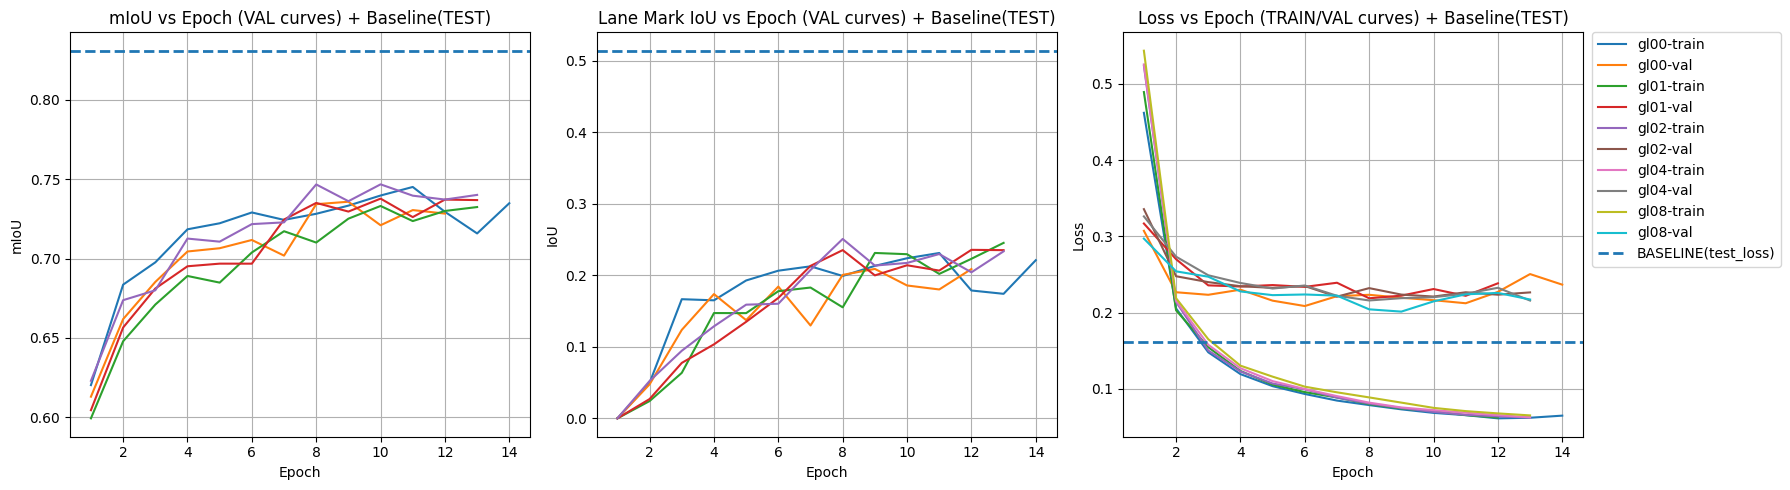


=== Best summary (per run, VAL best mIoU) ===
gl00                 | best_ep=11 | best_mIoU=0.7451 | laneIoU=0.2311
gl01                 | best_ep= 9 | best_mIoU=0.7358 | laneIoU=0.2089
gl02                 | best_ep=10 | best_mIoU=0.7332 | laneIoU=0.2294
gl04                 | best_ep=10 | best_mIoU=0.7378 | laneIoU=0.2140
gl08                 | best_ep=10 | best_mIoU=0.7468 | laneIoU=0.2173

=== BASELINE (TEST) recap ===
test_loss=0.1619 | test_mIoU=0.8310 | test_laneIoU=0.5139


In [181]:
# ============================================================
# ✅ Baseline(테스트) 기준선 + Gamma 실험 히스토리 시각화 (자동 패턴 탐색 버전)
# - Baseline 3개 고정 기준선:
#   1) test_loss
#   2) test_mIoU
#   3) test_lane_IoU (Lane Mark IoU)
#
# - 1행 3개 그래프:
#   (mIoU vs epoch + baseline test_mIoU)
#   (LaneMark IoU vs epoch + baseline test_lane_IoU)
#   (Loss vs epoch(train/val) + baseline test_loss)
# ============================================================

import os, glob
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 0) ✅ Baseline from your TEST BENCHMARK (고정값)
# =========================
BASE_TEST_LOSS = 0.1619
BASE_TEST_MIOU = 0.8310
BASE_TEST_LANE = 0.5139  # Lane Mark IoU

print("=== BASELINE (TEST) ===")
print("test_loss :", BASE_TEST_LOSS)
print("test_mIoU :", BASE_TEST_MIOU)
print("lane_iou  :", BASE_TEST_LANE)

# =========================
# 1) 히스토리 파일 자동 탐색
#    - GAMMAONLY / GAMMA_BRIGHT / history_* 전부 후보로 둠
# =========================
PATTERNS = [
    "history_deeplabv3_resnet50_GAMMAONLY_*.npz",
    "history_deeplabv3_resnet50_GAMMA_BRIGHT_gl*_bl*.npz",
    "history_deeplabv3_resnet50*.npz",
    "history_*.npz",
]

hist_files = []
picked_pattern = None
for p in PATTERNS:
    files = sorted(glob.glob(p))
    if len(files) > 0:
        hist_files = files
        picked_pattern = p
        break

# 현재 폴더 npz도 같이 출력(디버깅)
all_npz = sorted(glob.glob("*.npz"))
print("\n[DEBUG] npz files in current directory:", len(all_npz))
for f in all_npz[:50]:
    print(" -", f)
if len(all_npz) > 50:
    print(" ... (showing first 50)")

print("\nFound history files:", len(hist_files))
if picked_pattern is not None:
    print("Pattern used:", picked_pattern)

# 없으면 baseline만 그려주고 종료
if len(hist_files) == 0:
    print("\n⚠ No history npz found. (baseline lines only)")
    # baseline-only plot
    plt.figure(figsize=(18, 5))

    ax1 = plt.subplot(1, 3, 1)
    ax1.axhline(BASE_TEST_MIOU, linestyle="--", linewidth=2, label="BASELINE(test_mIoU)")
    ax1.set_title("mIoU vs Epoch (no history found)")
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("mIoU"); ax1.grid(True)

    ax2 = plt.subplot(1, 3, 2)
    ax2.axhline(BASE_TEST_LANE, linestyle="--", linewidth=2, label="BASELINE(test_lane_iou)")
    ax2.set_title("Lane Mark IoU vs Epoch (no history found)")
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("IoU"); ax2.grid(True)

    ax3 = plt.subplot(1, 3, 3)
    ax3.axhline(BASE_TEST_LOSS, linestyle="--", linewidth=2, label="BASELINE(test_loss)")
    ax3.set_title("Loss vs Epoch (no history found)")
    ax3.set_xlabel("Epoch"); ax3.set_ylabel("Loss"); ax3.grid(True)

    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()
    plt.show()

    raise SystemExit("Stop: history not found. Check SAVE_DIR/path/pattern.")

# =========================
# 2) LANE_IDX / LANE_NAME fallback
# =========================
LANE_NAME = globals().get("LANE_NAME", "Lane Mark")
LANE_IDX  = globals().get("LANE_IDX", None)

# =========================
# 3) 로드 + 파싱
# =========================
runs = []
for hf in hist_files:
    data = np.load(hf, allow_pickle=True)

    # 필수 키 체크(안 맞는 npz는 skip)
    required = ["epoch", "train_loss", "val_loss", "val_miou", "per_class_iou"]
    if not all(k in data.files for k in required):
        print(f"[SKIP] {hf} missing keys. has={data.files}")
        continue

    epoch = data["epoch"]
    tr    = data["train_loss"]
    va    = data["val_loss"]
    miou  = data["val_miou"]
    pciou = data["per_class_iou"]  # (E,C)

    # npz 안에 lane_idx 저장돼있으면 그걸 우선 사용 (없으면 현재 LANE_IDX 사용)
    if "lane_idx" in data.files:
        lane_idx = int(np.atleast_1d(data["lane_idx"])[0])
        if lane_idx < 0:
            lane_idx = None
    else:
        lane_idx = LANE_IDX

    if lane_idx is not None and pciou.ndim == 2 and 0 <= lane_idx < pciou.shape[1]:
        lane_curve = pciou[:, lane_idx]
    else:
        lane_curve = np.full(miou.shape, np.nan, dtype=np.float32)

    # tag: 파일명 기반 (GAMMAONLY / GAMMA_BRIGHT 둘 다 대응)
    base = os.path.basename(hf).replace(".npz", "")
    tag = base
    tag = tag.replace("history_deeplabv3_resnet50_GAMMA_BRIGHT_", "")
    tag = tag.replace("history_deeplabv3_resnet50_GAMMAONLY_", "")
    tag = tag.replace("history_deeplabv3_resnet50_", "")
    runs.append((tag, epoch, miou, lane_curve, tr, va))

print("\nValid runs loaded:", len(runs))
if len(runs) == 0:
    raise RuntimeError("History npz exists but none matched required keys.")

# =========================
# 4) ✅ 1행 3개 plot + baseline 기준선
# =========================
plt.figure(figsize=(18, 5))

# (1) mIoU vs epoch + baseline test_mIoU
ax1 = plt.subplot(1, 3, 1)
for tag, epoch, miou, lane_curve, tr, va in runs:
    ax1.plot(epoch, miou, label=tag)
ax1.axhline(BASE_TEST_MIOU, linestyle="--", linewidth=2, label="BASELINE(test_mIoU)")
ax1.set_title("mIoU vs Epoch (VAL curves) + Baseline(TEST)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("mIoU")
ax1.grid(True)

# (2) Lane Mark IoU vs epoch + baseline test_lane_iou
ax2 = plt.subplot(1, 3, 2)
for tag, epoch, miou, lane_curve, tr, va in runs:
    ax2.plot(epoch, lane_curve, label=tag)
ax2.axhline(BASE_TEST_LANE, linestyle="--", linewidth=2, label="BASELINE(test_lane_iou)")
ax2.set_title(f"{LANE_NAME} IoU vs Epoch (VAL curves) + Baseline(TEST)")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("IoU")
ax2.grid(True)

# (3) Loss vs epoch(train/val) + baseline test_loss
ax3 = plt.subplot(1, 3, 3)
for tag, epoch, miou, lane_curve, tr, va in runs:
    ax3.plot(epoch, tr, label=f"{tag}-train")
    ax3.plot(epoch, va, label=f"{tag}-val")
ax3.axhline(BASE_TEST_LOSS, linestyle="--", linewidth=2, label="BASELINE(test_loss)")
ax3.set_title("Loss vs Epoch (TRAIN/VAL curves) + Baseline(TEST)")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Loss")
ax3.grid(True)

# 범례: 길어지면 figure 밖으로
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()

# =========================
# 5) (옵션) run별 best 요약 (VAL 기준 best_mIoU)
# =========================
print("\n=== Best summary (per run, VAL best mIoU) ===")
for tag, epoch, miou, lane_curve, tr, va in runs:
    if np.all(np.isnan(miou)):
        print(f"{tag:20s} | best_ep=NA | best_mIoU=nan | laneIoU=nan")
        continue
    best_idx = int(np.nanargmax(miou))
    best_ep = int(epoch[best_idx])
    best_m = float(miou[best_idx])
    best_lane = float(lane_curve[best_idx]) if np.isfinite(lane_curve[best_idx]) else np.nan
    print(f"{tag:20s} | best_ep={best_ep:2d} | best_mIoU={best_m:.4f} | laneIoU={best_lane:.4f}")

print("\n=== BASELINE (TEST) recap ===")
print(f"test_loss={BASE_TEST_LOSS:.4f} | test_mIoU={BASE_TEST_MIOU:.4f} | test_laneIoU={BASE_TEST_LANE:.4f}")

In [183]:
rng = random.Random(SEED); rng.shuffle(all_img_ids)
train_ids = all_img_ids[:n_train]   # 160
val_ids   = all_img_ids[n_train:n_train+n_val] # 20